# SafePath Local Implementation — Notebook Overview

This project consists of six key Jupyter notebooks, documenting the full workflow from data preprocessing to routing API demonstration.

`DataCleaning.ipynb`
Initial preprocessing of raw datasets, including coordinate normalization, geocoding fixes, and removal of invalid records, keeping only valid Manhattan data from the past three years for later risk and routing analysis.

`DatabaseCreation.ipynb`
Created a PostGIS-enabled PostgreSQL database and standardized Manhattan tables, loading cleaned data into spatial structures for efficient routing queries.

`StreetGraphBuild.ipynb`
Built a walkable street network for Manhattan from OSM data and exported it into GeoJSON and graph structures for routing calculations.

`RiskScoringEngineer.ipynb`
Generated normalized crime-based risk scores for each street segment and categorized them into four safety levels for routing optimization.

`Routing_API.ipynb`
Inserted cleaned spatial records into a PostGIS database and validated geometry fields to support API-based safe routing queries.

`mongoDB_report.ipynb`
Enabled user-submitted safety reports with geospatial indexing in MongoDB, supporting nearby incident search for enhanced safety awareness.

# 1. Data Cleaning

### In this jupyter noteboook, all datasets we needed are cleaned and exported

In [9]:
import pandas as pd

path = "Complaint_Data_Historic.csv"
df = pd.read_csv(path)

# 1) Keep only the columns I want
keep_cols = [
    "CMPLNT_NUM",
    "BORO_NM",
    "CMPLNT_FR_DT",
    "CMPLNT_FR_TM",
    "LAW_CAT_CD",
    "PD_DESC",
    "PREM_TYP_DESC",
    "Latitude",
    "Longitude",
    "Lat_Lon"
]

clean = df[keep_cols].copy()

# 2) Clean text columns
text_cols = ["BORO_NM", "LAW_CAT_CD", "PD_DESC", "PREM_TYP_DESC"]
for c in text_cols:
    clean[c] = clean[c].astype("string").str.strip()

# 3) Make latitude / longitude numeric
for c in ["Latitude", "Longitude"]:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# 4) Drop any rows with missing values in these columns
clean = clean.dropna(how="any")

# 5) Parse date and filter by date range
clean["CMPLNT_FR_DT"] = pd.to_datetime(clean["CMPLNT_FR_DT"], errors="coerce")

start_date = pd.Timestamp("2023-01-01")
end_date   = pd.Timestamp("2024-12-31")

clean = clean[(clean["CMPLNT_FR_DT"] >= start_date) &
              (clean["CMPLNT_FR_DT"] <= end_date)]

# 6) Filter to Manhattan only
clean = clean[clean["BORO_NM"] == "MANHATTAN"]

# 7) Sort by date (newest first) and reset index
clean = clean.sort_values("CMPLNT_FR_DT", ascending=False).reset_index(drop=True)

# 8) Make all column names lowercase
clean.columns = [c.lower() for c in clean.columns]

# 9) Save to new CSV
clean.to_csv("Complaint_historic_cleaned.csv", index=False)

print("Cleaned shape:", clean.shape)
clean.head()

/var/folders/51/m0pq5ymd6snc2lzrfv1z1nw00000gn/T/ipykernel_19666/1084226331.py:4: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Cleaned shape: (267728, 10)


,cmplnt_num,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,law_cat_cd,pd_desc,prem_typ_desc,latitude,longitude,lat_lon
0,298702363,MANHATTAN,2024-12-31,21:40:00,MISDEMEANOR,ASSAULT 3,STREET,40.863997,-73.924890,"(40.863997, -73.92489)"
1,298686983,MANHATTAN,2024-12-31,11:30:00,MISDEMEANOR,"TRAFFIC,UNCLASSIFIED MISDEMEAN",STREET,40.757286,-73.978115,"(40.75728553363149, -73.97811527626749)"
2,298703706,MANHATTAN,2024-12-31,20:40:00,MISDEMEANOR,ASSAULT 3,STREET,40.756909,-73.990035,"(40.756909, -73.990035)"
3,298697875,MANHATTAN,2024-12-31,18:45:00,MISDEMEANOR,"WEAPONS, POSSESSION, ETC",RESIDENCE - APT. HOUSE,40.860560,-73.925726,"(40.86056, -73.925726)"
4,298703704,MANHATTAN,2024-12-31,20:40:00,MISDEMEANOR,ASSAULT 3,STREET,40.756909,-73.990035,"(40.756909, -73.990035)"


In [4]:
import pandas as pd

path = "Complaint_Year_To_Date.csv"   
df = pd.read_csv(path)

keep_cols = [
    "CMPLNT_NUM",
    "BORO_NM",
    "CMPLNT_FR_DT",
    "CMPLNT_FR_TM",
    "LAW_CAT_CD",
    "PD_DESC",
    "PREM_TYP_DESC",
    "Latitude",
    "Longitude",
    "Lat_Lon"
]

clean = df[keep_cols].copy()

# strip whitespace on text columns
text_cols = ["BORO_NM", "LAW_CAT_CD", "PD_DESC", "PREM_TYP_DESC"]
for c in text_cols:
    clean[c] = clean[c].astype("string").str.strip()

# numeric conversion
for c in ["Latitude", "Longitude"]:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# drop rows with any NA in these fields
clean = clean.dropna(how="any")

# parse date (for sorting only, no filtering)
clean["CMPLNT_FR_DT"] = pd.to_datetime(clean["CMPLNT_FR_DT"], errors="coerce")

# keep only MANHATTAN
clean = clean[clean["BORO_NM"] == "MANHATTAN"]

# sort newest → oldest
clean = clean.sort_values("CMPLNT_FR_DT", ascending=False).reset_index(drop=True)

# lowercase column names
clean.columns = [c.lower() for c in clean.columns]

# save
clean.to_csv("Complaint_ytd_cleaned.csv", index=False)

print("Cleaned shape:", clean.shape)
clean.head()

Cleaned shape: (103595, 10)


,cmplnt_num,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,law_cat_cd,pd_desc,prem_typ_desc,latitude,longitude,lat_lon
0,313716704,MANHATTAN,2025-09-30,13:20:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",STREET,40.705338,-74.004595,"(40.705338, -74.004595)"
1,313711113,MANHATTAN,2025-09-30,19:25:00,MISDEMEANOR,"CONTROLLED SUBSTANCE, POSSESSI",STREET,40.754700,-73.993502,"(40.7547, -73.993502)"
2,313730835,MANHATTAN,2025-09-30,14:30:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",RESIDENCE-HOUSE,40.818098,-73.946291,"(40.818098, -73.946291)"
3,313707726,MANHATTAN,2025-09-30,14:20:00,VIOLATION,IMITATION PISTOL/AIR RIFLE,PUBLIC SCHOOL,40.849011,-73.931193,"(40.849011, -73.931193)"
4,313702561,MANHATTAN,2025-09-30,15:50:00,MISDEMEANOR,"MENACING,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,40.780235,-73.945476,"(40.780235, -73.945476)"


In [18]:
import pandas as pd

# 1) load the two pre-cleaned files
hist = pd.read_csv("complaint_historic_cleaned.csv")
ytd  = pd.read_csv("complaint_ytd_cleaned.csv")

# 2) combine – YTD first, then historic (present → past)
complaints = pd.concat([ytd, hist], ignore_index=True)

# 3) make sure column names are lower-case (if not already)
complaints.columns = complaints.columns.str.lower()

# 4) enforce cmplnt_num as BIGINT-compatible
before = len(complaints)

complaints["cmplnt_num"] = pd.to_numeric(
    complaints["cmplnt_num"],
    errors="coerce"                      # bad ids -> NaN
)

complaints = complaints.dropna(subset=["cmplnt_num"])
after = len(complaints)
print("dropped rows with bad cmplnt_num:", before - after)

complaints["cmplnt_num"] = complaints["cmplnt_num"].astype("int64")

print("min id:", complaints["cmplnt_num"].min())
print("max id:", complaints["cmplnt_num"].max())
print("dtype:", complaints["cmplnt_num"].dtype)


# 6) export final cleaned file
complaints.to_csv("Complaint_cleaned.csv", index=False)
print("Saved complaints_manhattan_cleaned.csv with shape:", complaints.shape)
complaints.head()

dropped rows with bad cmplnt_num: 170
min id: 261181306
max id: 314074048
dtype: int64
Saved complaints_manhattan_cleaned.csv with shape: (371153, 10)


,cmplnt_num,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,law_cat_cd,pd_desc,prem_typ_desc,latitude,longitude,lat_lon
0,313716704,MANHATTAN,2025-09-30,13:20:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",STREET,40.705338,-74.004595,"(40.705338, -74.004595)"
1,313711113,MANHATTAN,2025-09-30,19:25:00,MISDEMEANOR,"CONTROLLED SUBSTANCE, POSSESSI",STREET,40.754700,-73.993502,"(40.7547, -73.993502)"
2,313730835,MANHATTAN,2025-09-30,14:30:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",RESIDENCE-HOUSE,40.818098,-73.946291,"(40.818098, -73.946291)"
3,313707726,MANHATTAN,2025-09-30,14:20:00,VIOLATION,IMITATION PISTOL/AIR RIFLE,PUBLIC SCHOOL,40.849011,-73.931193,"(40.849011, -73.931193)"
4,313702561,MANHATTAN,2025-09-30,15:50:00,MISDEMEANOR,"MENACING,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,40.780235,-73.945476,"(40.780235, -73.945476)"


In [6]:
import pandas as pd
import numpy as np

path = "Pedestrian_Crash_Data.csv"
df = pd.read_csv(path, low_memory=False)

# 1) Keep only needed columns
keep_cols = [
    "COLLISION_ID",
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED"
]
clean = df[keep_cols].copy()

# 2) Clean BOROUGH text and keep only MANHATTAN
clean["BOROUGH"] = clean["BOROUGH"].astype("string").str.strip()
clean = clean[clean["BOROUGH"] == "MANHATTAN"]

# 3) Convert numeric columns
num_cols = [
    "COLLISION_ID",
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED"
]
for c in num_cols:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# 4) Parse date
clean["CRASH DATE"] = pd.to_datetime(clean["CRASH DATE"], errors="coerce")

# 5) Treat (0,0) as missing lat/lon
clean.loc[
    (clean["LATITUDE"] == 0) & (clean["LONGITUDE"] == 0),
    ["LATITUDE", "LONGITUDE"]
] = np.nan

# 6) Drop any rows with NA in these kept columns
clean = clean.dropna(how="any")

# 7) Filter by date range
start = pd.Timestamp("2023-01-01")
end   = pd.Timestamp("2025-09-30")
clean = clean[(clean["CRASH DATE"] >= start) & (clean["CRASH DATE"] <= end)].copy()

# 8) Create Lat_Lon text column
clean["Lat_Lon"] = clean.apply(
    lambda r: f"({r['LATITUDE']}, {r['LONGITUDE']})",
    axis=1
)

# 9) Reorder columns (lat/long 3rd & 2nd last, Lat_Lon last)
new_order = [
    "COLLISION_ID",
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "LATITUDE",      
    "LONGITUDE",     
    "Lat_Lon"        
]
clean = clean[new_order]

# 10) Sort from present to past (newest first)
clean = clean.sort_values("CRASH DATE", ascending=False).reset_index(drop=True)

# 11) Make all column names lowercase
clean.columns = [c.lower() for c in clean.columns]

# 12) Save
out_file = "Crash_cleaned.csv"
clean.to_csv(out_file, index=False)

print("Saved:", out_file)
print("Cleaned shape:", clean.shape)
print("min date:", clean["crash date"].min())
print("max date:", clean["crash date"].max())
clean.head()

Saved: Crash_cleaned.csv
Cleaned shape: (32509, 9)
min date: 2023-01-01 00:00:00
max date: 2025-09-30 00:00:00


,collision_id,crash date,crash time,borough,number of pedestrians injured,number of pedestrians killed,latitude,longitude,lat_lon
0,4847893,2025-09-30,9:05,MANHATTAN,0,0,40.755253,-73.998660,"(40.755253, -73.99866)"
1,4846401,2025-09-30,9:03,MANHATTAN,0,0,40.755016,-73.978840,"(40.755016, -73.97884)"
2,4848427,2025-09-30,10:36,MANHATTAN,0,0,40.792130,-73.971770,"(40.79213, -73.97177)"
3,4849308,2025-09-30,7:10,MANHATTAN,0,0,40.771156,-73.981330,"(40.771156, -73.98133)"
4,4849022,2025-09-30,22:01,MANHATTAN,0,0,40.802532,-73.953026,"(40.802532, -73.953026)"


In [19]:
import pandas as pd
import numpy as np

path = "Pedestrian_Crash_Data.csv"
df = pd.read_csv(path, low_memory=False)

# 1) Keep only needed columns
keep_cols = [
    "COLLISION_ID",
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED"
]
clean = df[keep_cols].copy()

# 2) Clean BOROUGH text and keep only MANHATTAN
clean["BOROUGH"] = clean["BOROUGH"].astype("string").str.strip()
clean = clean[clean["BOROUGH"] == "MANHATTAN"]

# 3) Convert numeric columns
num_cols = [
    "COLLISION_ID",
    "LATITUDE",
    "LONGITUDE",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED"
]
for c in num_cols:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# 4) Parse date **with dayfirst=True** and then keep only the date part
clean["CRASH DATE"] = pd.to_datetime(
    clean["CRASH DATE"],
    dayfirst=True,          # <- important for 30/9/25 style dates
    errors="coerce"
)
clean["CRASH DATE"] = clean["CRASH DATE"].dt.date

# 5) Treat (0,0) as missing lat/lon
clean.loc[
    (clean["LATITUDE"] == 0) & (clean["LONGITUDE"] == 0),
    ["LATITUDE", "LONGITUDE"]
] = np.nan

# 6) Drop any rows with NA in these kept columns
clean = clean.dropna(how="any")

# 7) Filter by date range
start = pd.Timestamp("2023-01-01")
end   = pd.Timestamp("2025-09-30")
clean = clean[(pd.to_datetime(clean["CRASH DATE"]) >= start) &
              (pd.to_datetime(clean["CRASH DATE"]) <= end)].copy()

# 8) Create Lat_Lon text column
clean["Lat_Lon"] = clean.apply(
    lambda r: f"({r['LATITUDE']}, {r['LONGITUDE']})",
    axis=1
)

# 9) Reorder columns (lat/long 3rd & 2nd last, Lat_Lon last)
new_order = [
    "COLLISION_ID",
    "CRASH DATE",
    "CRASH TIME",
    "BOROUGH",
    "NUMBER OF PEDESTRIANS INJURED",
    "NUMBER OF PEDESTRIANS KILLED",
    "LATITUDE",
    "LONGITUDE",
    "Lat_Lon"
]
clean = clean[new_order]

# 10) Sort from present to past (newest first)
clean = clean.sort_values("CRASH DATE", ascending=False).reset_index(drop=True)

# 11) Standardise column names: lowercase + replace spaces with underscores
clean.columns = [c.strip().lower().replace(" ", "_") for c in clean.columns]
# Now we have: collision_id, crash_date, crash_time, borough, num..., latitude, longitude, lat_lon

# 12) Save
out_file = "Crash_cleaned.csv"
clean.to_csv(out_file, index=False)

print("Saved:", out_file)
print("Cleaned shape:", clean.shape)
print("min date:", clean["crash_date"].min())
print("max date:", clean["crash_date"].max())
clean.head()

/var/folders/51/m0pq5ymd6snc2lzrfv1z1nw00000gn/T/ipykernel_19666/2010639278.py:36: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  clean["CRASH DATE"] = pd.to_datetime(


Saved: Crash_cleaned.csv
Cleaned shape: (32509, 9)
min date: 2023-01-01
max date: 2025-09-30


,collision_id,crash_date,crash_time,borough,number_of_pedestrians_injured,number_of_pedestrians_killed,latitude,longitude,lat_lon
0,4847893,2025-09-30,9:05,MANHATTAN,0,0,40.755253,-73.998660,"(40.755253, -73.99866)"
1,4846401,2025-09-30,9:03,MANHATTAN,0,0,40.755016,-73.978840,"(40.755016, -73.97884)"
2,4848427,2025-09-30,10:36,MANHATTAN,0,0,40.792130,-73.971770,"(40.79213, -73.97177)"
3,4849308,2025-09-30,7:10,MANHATTAN,0,0,40.771156,-73.981330,"(40.771156, -73.98133)"
4,4849022,2025-09-30,22:01,MANHATTAN,0,0,40.802532,-73.953026,"(40.802532, -73.953026)"


In [7]:
import requests
import pandas as pd

url = "https://webcams.nyctmc.org/api/cameras"
resp = requests.get(url)
resp.raise_for_status()
data = resp.json()

df = pd.json_normalize(data)
print("Columns from API:", df.columns.tolist())

# 1) Select + rename columns
cams = df[["id", "name", "area", "isOnline", "latitude", "longitude"]].copy()
cams = cams.rename(columns={
    "id": "camera_id",
    "name": "camera_name",
    "area": "borough",
    "isOnline": "is_online",
    "latitude": "latitude",
    "longitude": "longitude"
})

# 2) Clean text columns
cams["borough"] = cams["borough"].astype("string").str.strip()
cams["camera_name"] = cams["camera_name"].astype("string").str.strip()

# 3) Standardise borough value to uppercase and keep only MANHATTAN
cams["borough"] = cams["borough"].str.upper()
cams = cams[cams["borough"] == "MANHATTAN"]

# 4) Normalise is_online to boolean-like True/False
cams["is_online"] = cams["is_online"].astype("string").str.lower().isin(["true", "1", "yes"])

# 5) Make latitude/longitude numeric
for c in ["latitude", "longitude"]:
    cams[c] = pd.to_numeric(cams[c], errors="coerce")

# 6) Drop rows with any NA and (0,0) coords
cams = cams.dropna(how="any")
cams = cams[(cams["latitude"] != 0) & (cams["longitude"] != 0)].copy()

# 7) Lat/Lon text column
cams["lat_lon"] = cams.apply(
    lambda r: f"({r['latitude']}, {r['longitude']})",
    axis=1
)

# 8) Reorder columns
cams = cams[[
    "camera_id",
    "camera_name",
    "borough",
    "is_online",
    "latitude",
    "longitude",
    "lat_lon"
]]

# 9) Make all column names lowercase
cams.columns = [c.lower() for c in cams.columns]

# 10) Save
out_file = "cameras_cleaned.csv"
cams.to_csv(out_file, index=False)
print("Saved:", out_file, "with shape:", cams.shape)

cams.head()

Columns from API: ['id', 'name', 'latitude', 'longitude', 'area', 'isOnline', 'imageUrl']
Saved: cameras_cleaned.csv with shape: (354, 7)


,camera_id,camera_name,borough,is_online,latitude,longitude,lat_lon
1,7f89db99-3420-4f7b-9f2a-edfc9014e8c1,Manhattan BBT Entrance,MANHATTAN,True,40.706251,-74.014347,"(40.706251, -74.014347)"
8,6726b334-f246-475b-9d1d-464dae09d403,BB-29 North East Manhattan Tower,MANHATTAN,True,40.707230,-73.998119,"(40.70723, -73.998119)"
9,98fc3e41-66be-42d7-8f69-5cc76ae7226f,BB - Manhattan hub - 156.103,MANHATTAN,True,40.710977,-74.003594,"(40.710977, -74.003594)"
12,9b648eba-3e4a-4c2c-9afc-e659c1083804,MHB-19 Manh N URDW @ Anch,MANHATTAN,True,40.710705,-73.992304,"(40.710705, -73.992304)"
14,c5040f93-f4ec-4803-8370-8b931b0443e2,FDR Dr @ 64 St,MANHATTAN,True,40.761186,-73.955676,"(40.761186, -73.955676)"


In [12]:
import pandas as pd
import numpy as np

path = "Arrest_Data_YTD.csv"
df = pd.read_csv(path, low_memory=False)

keep_cols = [
    "ARREST_KEY",
    "ARREST_DATE",
    "ARREST_BORO",
    "LAW_CAT_CD",
    "PD_DESC",
    "Latitude",
    "Longitude"
]

clean = df[keep_cols].copy()

# 1) Clean text columns
text_cols = ["ARREST_BORO", "LAW_CAT_CD", "PD_DESC"]
for c in text_cols:
    clean[c] = clean[c].astype("string").str.strip()

# 2) Keep only Manhattan: ARREST_BORO == "M"
clean = clean[clean["ARREST_BORO"] == "M"].copy()

# 3) Standardise ARREST_BORO to "MANHATTAN"
clean["ARREST_BORO"] = "MANHATTAN"

# 4) Numeric conversion
for c in ["ARREST_KEY", "Latitude", "Longitude"]:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# 5) Parse date
clean["ARREST_DATE"] = pd.to_datetime(clean["ARREST_DATE"], errors="coerce")

# 6) Drop rows with any NA and (0,0) coords
clean = clean.dropna(how="any")
clean = clean[(clean["Latitude"] != 0) & (clean["Longitude"] != 0)].copy()

# 7) Sort from present → past (newest date first, then biggest key)
clean = clean.sort_values(
    by=["ARREST_DATE", "ARREST_KEY"],
    ascending=[False, False]
).reset_index(drop=True)

# 8) Create Lat_Lon text column
clean["Lat_Lon"] = clean.apply(
    lambda r: f"({r['Latitude']}, {r['Longitude']})",
    axis=1
)

# 9) Make all column names lowercase
clean.columns = [c.lower() for c in clean.columns]

# 10) Save
out_file = "arrest_ytd_cleaned.csv"
clean.to_csv(out_file, index=False)

print("Cleaned shape:", clean.shape)
print("min date:", clean['arrest_date'].min())
print("max date:", clean['arrest_date'].max())
clean.head()

Cleaned shape: (50190, 8)
min date: 2025-01-01 00:00:00
max date: 2025-09-30 00:00:00


,arrest_key,arrest_date,arrest_boro,law_cat_cd,pd_desc,latitude,longitude,lat_lon
0,313730815,2025-09-30,MANHATTAN,F,"ASSAULT 2,1,UNCLASSIFIED",40.755316,-73.993052,"(40.755316, -73.993052)"
1,313723308,2025-09-30,MANHATTAN,F,"FORGERY,M.V. REGISTRATION",40.831568,-73.942981,"(40.83156784, -73.94298126)"
2,313721489,2025-09-30,MANHATTAN,M,"LARCENY,PETIT FROM OPEN AREAS,",40.765004,-73.964072,"(40.765004, -73.964072)"
3,313721488,2025-09-30,MANHATTAN,F,"ASSAULT 2,1,UNCLASSIFIED",40.836858,-73.937933,"(40.836858, -73.937933)"
4,313721487,2025-09-30,MANHATTAN,F,"BURGLARY,RESIDENCE,NIGHT",40.799655,-73.944042,"(40.799655, -73.944042)"


In [11]:
import pandas as pd
import numpy as np

path = "Arrests_Data_Historic.csv"
df = pd.read_csv(path, low_memory=False)

keep_cols = [
    "ARREST_KEY",
    "ARREST_DATE",
    "ARREST_BORO",
    "LAW_CAT_CD",
    "PD_DESC",
    "Latitude",
    "Longitude"
]
clean = df[keep_cols].copy()

# 1) Clean text columns
text_cols = ["ARREST_BORO", "LAW_CAT_CD", "PD_DESC"]
for c in text_cols:
    clean[c] = clean[c].astype("string").str.strip()

# 2) Keep only Manhattan (M) and standardize to MANHATTAN
clean = clean[clean["ARREST_BORO"] == "M"].copy()
clean["ARREST_BORO"] = "MANHATTAN"

# 3) Numeric conversion
for c in ["ARREST_KEY", "Latitude", "Longitude"]:
    clean[c] = pd.to_numeric(clean[c], errors="coerce")

# 4) Parse date
clean["ARREST_DATE"] = pd.to_datetime(clean["ARREST_DATE"], errors="coerce")

# 5) Filter by date range: 2023-01-01 to 2024-12-31
start_date = pd.Timestamp("2023-01-01")
end_date   = pd.Timestamp("2024-12-31")
clean = clean[(clean["ARREST_DATE"] >= start_date) &
              (clean["ARREST_DATE"] <= end_date)].copy()

# 6) Drop NA and (0,0) coordinates
clean = clean.dropna(how="any")
clean = clean[(clean["Latitude"] != 0) & (clean["Longitude"] != 0)].copy()

# 7) Sort from present → past (newest date, then largest key)
clean = clean.sort_values(
    by=["ARREST_DATE", "ARREST_KEY"],
    ascending=[False, False]
).reset_index(drop=True)

# 8) Create Lat_Lon text column
clean["Lat_Lon"] = clean.apply(
    lambda r: f"({r['Latitude']}, {r['Longitude']})",
    axis=1
)

# 9) Make all column names lowercase
clean.columns = [c.lower() for c in clean.columns]

# 10) Save
out_file = "Arrest_historic_cleaned.csv"
clean.to_csv(out_file, index=False)

print("Saved:", out_file)
print("Cleaned shape:", clean.shape)
print("min date:", clean["arrest_date"].min())
print("max date:", clean["arrest_date"].max())
clean.head()

Saved: Arrest_historic_cleaned.csv
Cleaned shape: (113336, 8)
min date: 2023-01-01 00:00:00
max date: 2024-12-31 00:00:00


,arrest_key,arrest_date,arrest_boro,law_cat_cd,pd_desc,latitude,longitude,lat_lon
0,298710721,2024-12-31,MANHATTAN,M,"PUBLIC ADMINISTATION,UNCLASS M",40.729586,-74.000846,"(40.729586, -74.000846)"
1,298707447,2024-12-31,MANHATTAN,F,"ASSAULT 2,1,UNCLASSIFIED",40.759767,-73.989812,"(40.759767, -73.989812)"
2,298707440,2024-12-31,MANHATTAN,F,CRIMINAL POSSESSION WEAPON,40.788318,-73.941018,"(40.78831825625, -73.94101767733)"
3,298707439,2024-12-31,MANHATTAN,F,STRANGULATION 1ST,40.848340,-73.933546,"(40.84834, -73.933546)"
4,298706305,2024-12-31,MANHATTAN,M,ASSAULT 3,40.848340,-73.933546,"(40.84834, -73.933546)"


In [13]:
import pandas as pd

# 1) Load both files
ytd_path  = "arrest_ytd_cleaned.csv"
hist_path = "arrest_historic_cleaned.csv"

df_ytd  = pd.read_csv(ytd_path)
df_hist = pd.read_csv(hist_path)

# 2) Ensure lowercase column names
df_ytd.columns  = [c.lower() for c in df_ytd.columns]
df_hist.columns = [c.lower() for c in df_hist.columns]

# 3) Combine with YTD first (so YTD has priority on duplicates)
combined = pd.concat([df_ytd, df_hist], ignore_index=True)

# 4) Defensive: keep only MANHATTAN (in case)
combined["arrest_boro"] = combined["arrest_boro"].astype("string").str.strip().str.upper()
combined = combined[combined["arrest_boro"] == "MANHATTAN"]

# 5) Drop duplicates by arrest_key, keeping the first (i.e., YTD)
combined = combined.drop_duplicates(subset="arrest_key", keep="first")

# 6) Parse date and sort from present → past
combined["arrest_date"] = pd.to_datetime(combined["arrest_date"], errors="coerce")
combined = combined.sort_values(
    by=["arrest_date", "arrest_key"],
    ascending=[False, False]
).reset_index(drop=True)

# 7) Save final combined file
out_file = "Arrest_cleaned.csv"
combined.to_csv(out_file, index=False)

print("Saved:", out_file)
print("Combined shape:", combined.shape)
print("min date:", combined['arrest_date'].min())
print("max date:", combined['arrest_date'].max())
combined.head()

Saved: Arrest_cleaned.csv
Combined shape: (163526, 8)
min date: 2023-01-01 00:00:00
max date: 2025-09-30 00:00:00


,arrest_key,arrest_date,arrest_boro,law_cat_cd,pd_desc,latitude,longitude,lat_lon
0,313730815,2025-09-30,MANHATTAN,F,"ASSAULT 2,1,UNCLASSIFIED",40.755316,-73.993052,"(40.755316, -73.993052)"
1,313723308,2025-09-30,MANHATTAN,F,"FORGERY,M.V. REGISTRATION",40.831568,-73.942981,"(40.83156784, -73.94298126)"
2,313721489,2025-09-30,MANHATTAN,M,"LARCENY,PETIT FROM OPEN AREAS,",40.765004,-73.964072,"(40.765004, -73.964072)"
3,313721488,2025-09-30,MANHATTAN,F,"ASSAULT 2,1,UNCLASSIFIED",40.836858,-73.937933,"(40.836858, -73.937933)"
4,313721487,2025-09-30,MANHATTAN,F,"BURGLARY,RESIDENCE,NIGHT",40.799655,-73.944042,"(40.799655, -73.944042)"


# 2. Database Creation

## Creating databse

In [1]:
import pandas as pd
from sqlalchemy import create_engine, text

USER = "postgres"          
PASSWORD = "AA123" 
HOST = "localhost"
PORT = "5432"

DB_NAME = "safepath_manhattan"

In [3]:
# connect to the maintenance database "postgres"
engine_root = create_engine(
    f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/postgres",
    echo=False
)

# CREATE DATABASE must run outside a transaction
with engine_root.connect().execution_options(isolation_level="AUTOCOMMIT") as conn:
    try:
        conn.execute(text(f"CREATE DATABASE {DB_NAME};"))
        print(f"Database {DB_NAME} created.")
    except Exception as e:
        print(f"CREATE DATABASE error (often safe to ignore if DB already exists): {e}")

Database safepath_manhattan created.


In [4]:
from sqlalchemy import create_engine, text

USER = "postgres"
PASSWORD = "AA123"
HOST = "localhost"
PORT = "5432"
DB_NAME = "safepath_manhattan"

engine = create_engine(
    f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}",
    echo=False
)

with engine.begin() as conn:
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS postgis;"))
    print("PostGIS extension ensured in", DB_NAME)

PostGIS extension ensured in safepath_manhattan


In [5]:
ddl = """
-- complaints in Manhattan
DROP TABLE IF EXISTS complaints_manhattan;
CREATE TABLE complaints_manhattan (
    complaint_id    BIGINT,
    borough         TEXT,
    event_date      TIMESTAMP,    -- from cmplnt_fr_dt
    event_time      TEXT,         -- from cmplnt_fr_tm
    law_cat_cd      TEXT,
    pd_desc         TEXT,
    prem_typ_desc   TEXT,
    latitude        DOUBLE PRECISION,
    longitude       DOUBLE PRECISION,
    lat_lon         TEXT,
    geom            geometry(Point, 4326)
);

-- arrests in Manhattan
DROP TABLE IF EXISTS arrests_manhattan;
CREATE TABLE arrests_manhattan (
    arrest_id       BIGINT,
    borough         TEXT,
    event_date      TIMESTAMP,    -- from arrest_date
    event_time      TEXT,         -- optional / can be NULL
    law_cat_cd      TEXT,
    pd_desc         TEXT,
    latitude        DOUBLE PRECISION,
    longitude       DOUBLE PRECISION,
    lat_lon         TEXT,
    geom            geometry(Point, 4326)
);

-- pedestrian crashes in Manhattan
DROP TABLE IF EXISTS crashes_manhattan;
CREATE TABLE crashes_manhattan (
    crash_id            BIGINT,
    borough             TEXT,
    event_date          DATE,     -- from crash_date
    event_time          TEXT,     -- from crash_time
    num_peds_injured    INTEGER,
    num_peds_killed     INTEGER,
    latitude            DOUBLE PRECISION,
    longitude           DOUBLE PRECISION,
    lat_lon             TEXT,
    geom                geometry(Point, 4326)
);

-- cameras in Manhattan
DROP TABLE IF EXISTS cameras_manhattan;
CREATE TABLE cameras_manhattan (
    camera_id   TEXT,             -- camera ids can be UUID-like
    camera_name TEXT,
    borough     TEXT,
    is_online   BOOLEAN,
    latitude    DOUBLE PRECISION,
    longitude   DOUBLE PRECISION,
    lat_lon     TEXT,
    geom        geometry(Point, 4326)
);
"""

with engine.begin() as conn:
    conn.execute(text(ddl))

print("Standardised Manhattan tables created.")

Standardised Manhattan tables created.


## Loading data

In [11]:
complaints_csv = "Complaint_cleaned.csv" 

complaints = pd.read_csv(complaints_csv, low_memory=False)

# make sure columns are lower case for consistency
complaints.columns = [c.lower() for c in complaints.columns]

# map old names → new table columns
complaints = complaints.rename(columns={
    "cmplnt_num":   "complaint_id",
    "boro_nm":      "borough",
    "cmplnt_fr_dt": "event_date",
    "cmplnt_fr_tm": "event_time",
    # law_cat_cd, pd_desc, prem_typ_desc, latitude, longitude, lat_lon
    # should already match or be lower case
})

# keep only columns our table has
complaints = complaints[[
    "complaint_id",
    "borough",
    "event_date",
    "event_time",
    "law_cat_cd",
    "pd_desc",
    "prem_typ_desc",
    "latitude",
    "longitude",
    "lat_lon"
]]

complaints.to_sql(
    "complaints_manhattan",
    engine,
    if_exists="append",
    index=False
)

print("Inserted rows into complaints_manhattan:", len(complaints))
complaints.head()

Inserted rows into complaints_manhattan: 371153


,complaint_id,borough,event_date,event_time,law_cat_cd,pd_desc,prem_typ_desc,latitude,longitude,lat_lon
0,313716704,MANHATTAN,2025-09-30,13:20:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",STREET,40.705338,-74.004595,"(40.705338, -74.004595)"
1,313711113,MANHATTAN,2025-09-30,19:25:00,MISDEMEANOR,"CONTROLLED SUBSTANCE, POSSESSI",STREET,40.754700,-73.993502,"(40.7547, -73.993502)"
2,313730835,MANHATTAN,2025-09-30,14:30:00,VIOLATION,"HARASSMENT,SUBD 3,4,5",RESIDENCE-HOUSE,40.818098,-73.946291,"(40.818098, -73.946291)"
3,313707726,MANHATTAN,2025-09-30,14:20:00,VIOLATION,IMITATION PISTOL/AIR RIFLE,PUBLIC SCHOOL,40.849011,-73.931193,"(40.849011, -73.931193)"
4,313702561,MANHATTAN,2025-09-30,15:50:00,MISDEMEANOR,"MENACING,UNCLASSIFIED",RESIDENCE - PUBLIC HOUSING,40.780235,-73.945476,"(40.780235, -73.945476)"


In [8]:
arrests_csv = "Arrest_cleaned.csv"

arrests = pd.read_csv(arrests_csv, low_memory=False)

arrests.columns = [c.lower() for c in arrests.columns]

arrests = arrests.rename(columns={
    "arrest_key":  "arrest_id",
    "arrest_boro": "borough",
    "arrest_date": "event_date"
    # law_cat_cd, pd_desc, latitude, longitude, lat_lon should already match
})

# if there is no time column, create an empty one
if "event_time" not in arrests.columns:
    arrests["event_time"] = pd.NA

arrests = arrests[[
    "arrest_id",
    "borough",
    "event_date",
    "event_time",
    "law_cat_cd",
    "pd_desc",
    "latitude",
    "longitude",
    "lat_lon"
]]

arrests.to_sql(
    "arrests_manhattan",
    engine,
    if_exists="append",
    index=False
)

print("Inserted rows into arrests_manhattan:", len(arrests))
arrests.head()

Inserted rows into arrests_manhattan: 163526


,arrest_id,borough,event_date,event_time,law_cat_cd,pd_desc,latitude,longitude,lat_lon
0,313730815,MANHATTAN,2025-09-30,<NA>,F,"ASSAULT 2,1,UNCLASSIFIED",40.755316,-73.993052,"(40.755316, -73.993052)"
1,313723308,MANHATTAN,2025-09-30,<NA>,F,"FORGERY,M.V. REGISTRATION",40.831568,-73.942981,"(40.83156784, -73.94298126)"
2,313721489,MANHATTAN,2025-09-30,<NA>,M,"LARCENY,PETIT FROM OPEN AREAS,",40.765004,-73.964072,"(40.765004, -73.964072)"
3,313721488,MANHATTAN,2025-09-30,<NA>,F,"ASSAULT 2,1,UNCLASSIFIED",40.836858,-73.937933,"(40.836858, -73.937933)"
4,313721487,MANHATTAN,2025-09-30,<NA>,F,"BURGLARY,RESIDENCE,NIGHT",40.799655,-73.944042,"(40.799655, -73.944042)"


In [10]:
cams_csv = "cameras_cleaned.csv"   # TODO: your file from the API step

# force camera_id to string so it stays TEXT
cams = pd.read_csv(cams_csv, dtype={"camera_id": "string"}, low_memory=False)

cams.columns = [c.lower() for c in cams.columns]

# If your CSV already has the correct names, this is just a safety rename:
cams = cams.rename(columns={
    "camera_id":   "camera_id",
    "camera_name": "camera_name",
    "borough":     "borough",
    "is_online":   "is_online",
    "latitude":    "latitude",
    "longitude":   "longitude",
    "lat_lon":     "lat_lon"
})

cams = cams[[
    "camera_id",
    "camera_name",
    "borough",
    "is_online",
    "latitude",
    "longitude",
    "lat_lon"
]]

cams.to_sql(
    "cameras_manhattan",
    engine,
    if_exists="append",
    index=False
)

print("Inserted rows into cameras_manhattan:", len(cams))
cams.head()

Inserted rows into cameras_manhattan: 354


,camera_id,camera_name,borough,is_online,latitude,longitude,lat_lon
0,7f89db99-3420-4f7b-9f2a-edfc9014e8c1,Manhattan BBT Entrance,MANHATTAN,True,40.706251,-74.014347,"(40.706251, -74.014347)"
1,6726b334-f246-475b-9d1d-464dae09d403,BB-29 North East Manhattan Tower,MANHATTAN,True,40.707230,-73.998119,"(40.70723, -73.998119)"
2,98fc3e41-66be-42d7-8f69-5cc76ae7226f,BB - Manhattan hub - 156.103,MANHATTAN,True,40.710977,-74.003594,"(40.710977, -74.003594)"
3,9b648eba-3e4a-4c2c-9afc-e659c1083804,MHB-19 Manh N URDW @ Anch,MANHATTAN,True,40.710705,-73.992304,"(40.710705, -73.992304)"
4,c5040f93-f4ec-4803-8370-8b931b0443e2,FDR Dr @ 64 St,MANHATTAN,True,40.761186,-73.955676,"(40.761186, -73.955676)"


In [14]:
# --- 1) read cleaned CSV, parse crash_date as datetime ---
crashes = pd.read_csv(
    "Crash_cleaned.csv",
    low_memory=False,
    parse_dates=["crash_date"]   # ensures proper datetime instead of "30/9/25"
)

# --- 2) rename columns to match table schema ---
crashes = crashes.rename(columns={
    "collision_id":                   "crash_id",
    "crash_date":                     "event_date",
    "crash_time":                     "event_time",
    "number_of_pedestrians_injured":  "num_peds_injured",
    "number_of_pedestrians_killed":   "num_peds_killed"
    # borough, latitude, longitude, lat_lon already fine
})

# --- 3) make sure dtypes line up with table definition ---

# crash_id -> BIGINT
crashes["crash_id"] = pd.to_numeric(crashes["crash_id"], errors="coerce").astype("int64")

# event_date -> DATE (keep only the date part)
crashes["event_date"] = pd.to_datetime(crashes["event_date"], errors="coerce").dt.date

# num_peds_* -> INTEGER
crashes["num_peds_injured"] = pd.to_numeric(crashes["num_peds_injured"], errors="coerce").astype("int64")
crashes["num_peds_killed"]  = pd.to_numeric(crashes["num_peds_killed"],  errors="coerce").astype("int64")

# latitude / longitude -> DOUBLE PRECISION
crashes["latitude"]  = pd.to_numeric(crashes["latitude"],  errors="coerce")
crashes["longitude"] = pd.to_numeric(crashes["longitude"], errors="coerce")

# --- 4) keep only columns the table has, in the same order ---
crashes = crashes[[
    "crash_id",
    "borough",
    "event_date",
    "event_time",
    "num_peds_injured",
    "num_peds_killed",
    "latitude",
    "longitude",
    "lat_lon"
]]

# --- 5) insert into crashes_manhattan ---
crashes.to_sql(
    "crashes_manhattan",
    engine,
    if_exists="append",   # table already created
    index=False
)

print("Inserted rows into crashes_manhattan:", len(crashes))
crashes.head()

Inserted rows into crashes_manhattan: 32509


,crash_id,borough,event_date,event_time,num_peds_injured,num_peds_killed,latitude,longitude,lat_lon
0,4847893,MANHATTAN,2025-09-30,9:05,0,0,40.755253,-73.998660,"(40.755253, -73.99866)"
1,4846401,MANHATTAN,2025-09-30,9:03,0,0,40.755016,-73.978840,"(40.755016, -73.97884)"
2,4848427,MANHATTAN,2025-09-30,10:36,0,0,40.792130,-73.971770,"(40.79213, -73.97177)"
3,4849308,MANHATTAN,2025-09-30,7:10,0,0,40.771156,-73.981330,"(40.771156, -73.98133)"
4,4849022,MANHATTAN,2025-09-30,22:01,0,0,40.802532,-73.953026,"(40.802532, -73.953026)"


In [15]:
from sqlalchemy import create_engine, text
from sqlalchemy import create_engine, text

USER = "postgres"
PASSWORD = "AA123"
HOST = "localhost"
PORT = "5432"
DB_NAME = "safepath_manhattan"

engine = create_engine(
    f"postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB_NAME}",
    echo=False
)

sql = """
-- complaints (Manhattan)
UPDATE complaints_manhattan
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)
WHERE geom IS NULL
  AND longitude IS NOT NULL
  AND latitude  IS NOT NULL;

-- arrests (Manhattan)
UPDATE arrests_manhattan
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)
WHERE geom IS NULL
  AND longitude IS NOT NULL
  AND latitude  IS NOT NULL;

-- crashes (Manhattan)
UPDATE crashes_manhattan
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)
WHERE geom IS NULL
  AND longitude IS NOT NULL
  AND latitude  IS NOT NULL;

-- cctv cameras (Manhattan)
UPDATE cameras_manhattan
SET geom = ST_SetSRID(ST_MakePoint(longitude, latitude), 4326)
WHERE geom IS NULL
  AND longitude IS NOT NULL
  AND latitude  IS NOT NULL;
"""

with engine.begin() as conn:
    conn.execute(text(sql))

print("geom populated for complaints, arrests, crashes, cameras.")

geom populated for complaints, arrests, crashes, cameras.
geom populated for complaints, arrests, crashes, cameras.


In [16]:
from sqlalchemy import text

tables = [
    "complaints_manhattan",
    "arrests_manhattan",
    "crashes_manhattan",
    "cameras_manhattan"
]

with engine.connect() as conn:
    for t in tables:
        total = conn.execute(text(f"SELECT COUNT(*) FROM {t};")).scalar()
        with_geom = conn.execute(text(f"SELECT COUNT(*) FROM {t} WHERE geom IS NOT NULL;")).scalar()
        print(f"{t}: {with_geom}/{total} rows have geom")

complaints_manhattan: 371153/371153 rows have geom
arrests_manhattan: 163526/163526 rows have geom
crashes_manhattan: 32509/32509 rows have geom
cameras_manhattan: 354/354 rows have geom


In [17]:
sql_indexes = """
CREATE INDEX IF NOT EXISTS idx_complaints_manhattan_geom
  ON complaints_manhattan
  USING GIST (geom);

CREATE INDEX IF NOT EXISTS idx_arrests_manhattan_geom
  ON arrests_manhattan
  USING GIST (geom);

CREATE INDEX IF NOT EXISTS idx_crashes_manhattan_geom
  ON crashes_manhattan
  USING GIST (geom);

CREATE INDEX IF NOT EXISTS idx_cameras_manhattan_geom
  ON cameras_manhattan
  USING GIST (geom);
"""

with engine.begin() as conn:
    conn.execute(text(sql_indexes))

print("Spatial GIST indexes created (or already existed).")

Spatial GIST indexes created (or already existed).


In [18]:
check_sql = """
SELECT tablename, indexname
FROM pg_indexes
WHERE tablename IN (
  'complaints_manhattan',
  'arrests_manhattan',
  'crashes_manhattan',
  'cameras_manhattan'
)
ORDER BY tablename, indexname;
"""

with engine.connect() as conn:
    rows = conn.execute(text(check_sql)).fetchall()

for r in rows:
    print(r)

('arrests_manhattan', 'idx_arrests_manhattan_geom')
('cameras_manhattan', 'idx_cameras_manhattan_geom')
('complaints_manhattan', 'idx_complaints_manhattan_geom')
('crashes_manhattan', 'idx_crashes_manhattan_geom')


## Building edges

In [19]:
pip install osmnx geopandas

Note: you may need to restart the kernel to use updated packages.


In [20]:
import osmnx as ox
import geopandas as gpd

# 1) download walking network for **Manhattan only**
place = "Manhattan, New York City, New York, USA"
G = ox.graph_from_place(place, network_type="walk")

# 2) convert to nodes/edges GeoDataFrames
nodes, edges = ox.graph_to_gdfs(G)

# 3) keep only useful columns
edges = edges.reset_index()
edges = edges[["u", "v", "key", "osmid", "highway", "name", "length", "geometry"]]

# 4) make an integer edge_id (for BIGINT in Postgres)
edges["edge_id"] = edges.index.astype("int64")

edges.head()

,u,v,key,osmid,highway,name,length,geometry,edge_id
0,30807314,2057103273,0,46613689,bridleway,NaN,159.255042,"LINESTRING (-73.96358 40.79072, -73.9636 40.79...",0
1,30807314,6579409036,0,46613689,bridleway,NaN,58.144181,"LINESTRING (-73.96358 40.79072, -73.96354 40.7...",1
2,30807314,4303265016,0,147089927,footway,NaN,10.509449,"LINESTRING (-73.96358 40.79072, -73.96353 40.7...",2
3,30807314,1203806304,0,147089927,footway,NaN,17.645411,"LINESTRING (-73.96358 40.79072, -73.96368 40.7...",3
4,30978747,42442164,0,429504381,path,Central Park Driveway,18.986534,"LINESTRING (-73.97342 40.77427, -73.97365 40.7...",4


In [21]:
print("rows in edges:", len(edges))
print("shape:", edges.shape)

rows in edges: 120016
shape: (120016, 9)


In [22]:
import pandas as pd

# keep only needed columns
cols = ["edge_id", "u", "v", "osmid", "highway", "name", "length", "geometry"]
edges_simple = edges[cols].copy()

# geometry → WKT string
edges_simple["wkt"] = edges_simple["geometry"].apply(lambda g: g.wkt)

# drop geometry before sending to Postgres
edges_csv = edges_simple.drop(columns=["geometry"])

csv_path = "edges_manhattan.csv"
edges_csv.to_csv(csv_path, index=False)

print("Saved:", csv_path)
print("Rows in CSV:", len(edges_csv))
edges_csv.head()

Saved: edges_manhattan.csv
Rows in CSV: 120016


,edge_id,u,v,osmid,highway,name,length,wkt
0,0,30807314,2057103273,46613689,bridleway,NaN,159.255042,"LINESTRING (-73.9635764 40.7907204, -73.963601..."
1,1,30807314,6579409036,46613689,bridleway,NaN,58.144181,"LINESTRING (-73.9635764 40.7907204, -73.963544..."
2,2,30807314,4303265016,147089927,footway,NaN,10.509449,"LINESTRING (-73.9635764 40.7907204, -73.963525..."
3,3,30807314,1203806304,147089927,footway,NaN,17.645411,"LINESTRING (-73.9635764 40.7907204, -73.963678..."
4,4,30978747,42442164,429504381,path,Central Park Driveway,18.986534,"LINESTRING (-73.973425 40.7742666, -73.973649 ..."


In [23]:
from sqlalchemy import text

with engine.begin() as conn:
    conn.execute(text("""
        DROP TABLE IF EXISTS edges_manhattan;

        CREATE TABLE edges_manhattan (
            edge_id BIGINT PRIMARY KEY,
            u       BIGINT,
            v       BIGINT,
            osmid   TEXT,
            highway TEXT,
            name    TEXT,
            length  DOUBLE PRECISION,
            wkt     TEXT,                         -- raw WKT from CSV
            geom    geometry(LINESTRING, 4326)    -- real geometry
        );
    """))

print("Table edges_manhattan created.")

Table edges_manhattan created.


In [25]:
edges_csv = pd.read_csv("edges_manhattan.csv")

edges_csv.to_sql(
    "edges_manhattan",
    engine,
    if_exists="append",
    index=False
)

print("Inserted rows into edges_manhattan:", len(edges_csv))

Inserted rows into edges_manhattan: 120016


In [26]:
from sqlalchemy import text

with engine.begin() as conn:
    conn.execute(text("""
        -- fill geom from wkt
        UPDATE edges_manhattan
        SET geom = ST_GeomFromText(wkt, 4326)
        WHERE geom IS NULL AND wkt IS NOT NULL;

        -- spatial index
        CREATE INDEX IF NOT EXISTS idx_edges_manhattan_geom
        ON edges_manhattan
        USING GIST (geom);

        ANALYZE edges_manhattan;
    """))

print("geom filled and spatial index created on edges_manhattan.")

geom filled and spatial index created on edges_manhattan.


In [27]:
from sqlalchemy import text

with engine.connect() as conn:
    n = conn.execute(text("SELECT COUNT(*) FROM edges_manhattan;")).scalar()
    print("Rows in edges_manhattan:", n)

Rows in edges_manhattan: 120016


## Sptial join

In [28]:
from sqlalchemy import text

with engine.begin() as conn:
    conn.execute(text("""
        -- edges
        CREATE INDEX IF NOT EXISTS idx_edges_manhattan_geom
        ON edges_manhattan
        USING GIST (geom);

        -- complaints
        CREATE INDEX IF NOT EXISTS idx_complaints_manhattan_geom
        ON complaints_manhattan
        USING GIST (geom);

        -- arrests
        CREATE INDEX IF NOT EXISTS idx_arrests_manhattan_geom
        ON arrests_manhattan
        USING GIST (geom);

        -- crashes
        CREATE INDEX IF NOT EXISTS idx_crashes_manhattan_geom
        ON crashes_manhattan
        USING GIST (geom);

        -- cameras
        CREATE INDEX IF NOT EXISTS idx_cameras_manhattan_geom
        ON cameras_manhattan
        USING GIST (geom);
    """))

print("Spatial indexes ensured.")

Spatial indexes ensured.


## Edge–Events Dataset

In [46]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    tables = pd.read_sql(
        text("""
        SELECT table_name
        FROM information_schema.tables
        WHERE table_schema = 'public'
        ORDER BY table_name;
        """),
        conn
    )

print(tables)

               table_name
0       arrests_manhattan
1       cameras_manhattan
2    complaints_manhattan
3       crashes_manhattan
4      edge_arrest_counts
5        edge_cctv_counts
6   edge_complaint_counts
7       edge_crash_counts
8         edges_manhattan
9       geography_columns
10       geometry_columns
11        spatial_ref_sys


In [50]:
from sqlalchemy import text

sql_cctv_mh_fix = """
DROP TABLE IF EXISTS edge_cctv_counts_mh;

CREATE TABLE edge_cctv_counts_mh AS
SELECT
    e.edge_id,
    COUNT(cam.camera_id) AS cctv_cnt
FROM edges_manhattan e
LEFT JOIN cameras_manhattan cam
    ON ST_DWithin(cam.geom, e.geom, 0.00018)  -- ~20m near NYC
GROUP BY e.edge_id
ORDER BY e.edge_id;
"""

with engine.begin() as conn:
    conn.execute(text(sql_cctv_mh_fix))

print("edge_cctv_counts_mh recreated.")

edge_cctv_counts_mh recreated.


In [51]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    head_cctv = pd.read_sql(
        text("SELECT * FROM edge_cctv_counts_mh ORDER BY edge_id LIMIT 20;"),
        conn
    )

print(head_cctv)

    edge_id  cctv_cnt
0         0         0
1         1         0
2         2         0
3         3         0
4         4         0
5         5         0
6         6         0
7         7         0
8         8         0
9         9         0
10       10         0
11       11         0
12       12         0
13       13         0
14       14         0
15       15         0
16       16         0
17       17         0
18       18         0
19       19         0


In [52]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    # 1) How many edges have at least one camera?
    n_nonzero = conn.execute(
        text("SELECT COUNT(*) FROM edge_cctv_counts_mh WHERE cctv_cnt > 0;")
    ).scalar()
    print("Edges with cctv_cnt > 0:", n_nonzero)

    if n_nonzero > 0:
        # 2) Show the first few non-zero rows
        nonzero_head = pd.read_sql(
            text("""
                SELECT *
                FROM edge_cctv_counts_mh
                WHERE cctv_cnt > 0
                ORDER BY edge_id
                LIMIT 20;
            """),
            conn
        )
        print(nonzero_head)
    else:
        print("No edges have cctv_cnt > 0 – the spatial join is finding zero matches.")

Edges with cctv_cnt > 0: 4672
    edge_id  cctv_cnt
0        69         1
1        70         1
2        71         2
3        73         1
4        74         1
5        75         1
6       109         1
7       110         1
8       118         1
9       119         1
10      120         1
11      122         1
12      123         1
13      124         1
14      144         1
15      145         1
16      146         1
17      149         1
18      314         1
19      358         1


In [53]:
from sqlalchemy import text

sql_crash_mh = """
DROP TABLE IF EXISTS edge_crash_counts_mh;

CREATE TABLE edge_crash_counts_mh AS
SELECT
    e.edge_id,
    COUNT(cr.crash_id) AS crash_cnt
FROM edges_manhattan e
LEFT JOIN crashes_manhattan cr
    ON ST_DWithin(cr.geom, e.geom, 0.00018)  -- ~20m near NYC
GROUP BY e.edge_id
ORDER BY e.edge_id;
"""

with engine.begin() as conn:
    conn.execute(text(sql_crash_mh))

print("edge_crash_counts_mh created.")

edge_crash_counts_mh created.


In [54]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    head_crash = pd.read_sql(
        text("SELECT * FROM edge_crash_counts_mh ORDER BY edge_id LIMIT 20;"),
        conn
    )
    print("First 20 rows:")
    print(head_crash)

    nonzero_crash = pd.read_sql(
        text("""
            SELECT COUNT(*) AS edges_with_crashes
            FROM edge_crash_counts_mh
            WHERE crash_cnt > 0;
        """),
        conn
    )
    print("\nEdges with crash_cnt > 0:")
    print(nonzero_crash)

First 20 rows:
    edge_id  crash_cnt
0         0          0
1         1          0
2         2          0
3         3          0
4         4          0
5         5          0
6         6          0
7         7          0
8         8          0
9         9          0
10       10          0
11       11          0
12       12          1
13       13          1
14       14          1
15       15          0
16       16          0
17       17          1
18       18          0
19       19          1

Edges with crash_cnt > 0:
   edges_with_crashes
0               77296


In [56]:
from sqlalchemy import text

# 20 m in degrees ≈ 0.00018 near NYC
sql_complaint_mh = """
DROP TABLE IF EXISTS edge_complaint_counts_mh;

CREATE TABLE edge_complaint_counts_mh AS
SELECT
    e.edge_id,
    COUNT(c.complaint_id) AS complaint_cnt
FROM edges_manhattan e
LEFT JOIN complaints_manhattan c
    ON ST_DWithin(c.geom, e.geom, 0.00018)  -- ~20 m near NYC
GROUP BY e.edge_id
ORDER BY e.edge_id;
"""

with engine.begin() as conn:
    conn.execute(text(sql_complaint_mh))

print("edge_complaint_counts_mh created.")

edge_complaint_counts_mh created.


In [60]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    total_nonzero = pd.read_sql(
        text("""
            SELECT COUNT(*) AS n
            FROM edge_complaint_counts_mh
            WHERE complaint_cnt > 0;
        """),
        conn
    )["n"].iloc[0]

print("Total edges with complaint_cnt > 0:", total_nonzero)

Total edges with complaint_cnt > 0: 81506


In [58]:
from sqlalchemy import text

sql_arrest_mh = """
DROP TABLE IF EXISTS edge_arrest_counts_mh;

CREATE TABLE edge_arrest_counts_mh AS
SELECT
    e.edge_id,
    COUNT(a.arrest_id) AS arrest_cnt
FROM edges_manhattan e
LEFT JOIN arrests_manhattan a
    ON ST_DWithin(a.geom, e.geom, 0.00018)  -- ~20 m near NYC
GROUP BY e.edge_id
ORDER BY e.edge_id;
"""

with engine.begin() as conn:
    conn.execute(text(sql_arrest_mh))

print("edge_arrest_counts_mh created.")

edge_arrest_counts_mh created.


In [61]:
import pandas as pd
from sqlalchemy import text

with engine.connect() as conn:
    total_nonzero = pd.read_sql(
        text("""
            SELECT COUNT(*) AS n
            FROM edge_arrest_counts_mh
            WHERE arrest_cnt > 0;
        """),
        conn
    )["n"].iloc[0]

print("Total edges with complaint_cnt > 0:", total_nonzero)

Total edges with complaint_cnt > 0: 74284


In [62]:
import pandas as pd
from sqlalchemy import text

COMBINED_SQL = """
SELECT
    e.edge_id,
    e.u,
    e.v,
    e.osmid,
    e.highway,
    e.name,
    e.length,
    ST_AsText(e.geom) AS geom_wkt,   -- keep geometry as WKT text for CSV

    COALESCE(c.complaint_cnt, 0) AS complaint_cnt,
    COALESCE(a.arrest_cnt,     0) AS arrest_cnt,
    COALESCE(cr.crash_cnt,     0) AS crash_cnt,
    COALESCE(cc.cctv_cnt,      0) AS cctv_cnt,

    -- convenient total incidents
    COALESCE(c.complaint_cnt, 0)
  + COALESCE(a.arrest_cnt,     0)
  + COALESCE(cr.crash_cnt,     0)
  + COALESCE(cc.cctv_cnt,      0) AS total_incidents

FROM edges_manhattan e
LEFT JOIN edge_complaint_counts_mh c
       ON e.edge_id = c.edge_id
LEFT JOIN edge_arrest_counts_mh a
       ON e.edge_id = a.edge_id
LEFT JOIN edge_crash_counts_mh cr
       ON e.edge_id = cr.edge_id
LEFT JOIN edge_cctv_counts_mh cc
       ON e.edge_id = cc.edge_id
ORDER BY e.edge_id;
"""

with engine.connect() as conn:
    edges_all = pd.read_sql(text(COMBINED_SQL), conn)

print("Combined shape:", edges_all.shape)
edges_all.head()

Combined shape: (120016, 13)


,edge_id,u,v,osmid,highway,name,length,geom_wkt,complaint_cnt,arrest_cnt,crash_cnt,cctv_cnt,total_incidents
0,0,30807314,2057103273,46613689,bridleway,None,159.255042,"LINESTRING(-73.9635764 40.7907204,-73.9636016 ...",0,0,0,0,0
1,1,30807314,6579409036,46613689,bridleway,None,58.144181,"LINESTRING(-73.9635764 40.7907204,-73.9635442 ...",0,0,0,0,0
2,2,30807314,4303265016,147089927,footway,None,10.509449,"LINESTRING(-73.9635764 40.7907204,-73.9635256 ...",0,0,0,0,0
3,3,30807314,1203806304,147089927,footway,None,17.645411,"LINESTRING(-73.9635764 40.7907204,-73.9636781 ...",0,0,0,0,0
4,4,30978747,42442164,429504381,path,Central Park Driveway,18.986534,"LINESTRING(-73.973425 40.7742666,-73.973649 40...",0,0,0,0,0


In [63]:
from sqlalchemy import text

with engine.connect() as conn:
    n_edges = pd.read_sql(text("SELECT COUNT(*) AS n FROM edges_manhattan;"), conn)["n"].iloc[0]

print("rows in edges_manhattan:", n_edges)
print("rows in combined DataFrame:", len(edges_all))

rows in edges_manhattan: 120016
rows in combined DataFrame: 120016


In [64]:
edges_all[["complaint_cnt", "arrest_cnt", "crash_cnt", "cctv_cnt", "total_incidents"]].describe()
# how many edges have at least 1 incident
nonzero_edges = (edges_all[["complaint_cnt", "arrest_cnt", "crash_cnt", "cctv_cnt"]]
                 .sum(axis=1) > 0).sum()
print("Edges with any incidents >", 0, ":", nonzero_edges)

# sample a few edges with incidents
edges_all[edges_all["total_incidents"] > 0].head(20)

Edges with any incidents > 0 : 87336


,edge_id,u,v,osmid,highway,name,length,geom_wkt,complaint_cnt,arrest_cnt,crash_cnt,cctv_cnt,total_incidents
12,12,42421731,10171363561,5671485,residential,Manhattan Avenue,10.773193,"LINESTRING(-73.9614745 40.7986542,-73.9615364 ...",5,3,1,0,9
13,13,42421731,10171363559,420625565,secondary,West 106th Street,8.214984,"LINESTRING(-73.9614745 40.7986542,-73.9613898 ...",5,3,1,0,9
14,14,42421731,10171363562,420625570,secondary,West 106th Street,10.156774,"LINESTRING(-73.9614745 40.7986542,-73.9615798 ...",5,3,1,0,9
15,15,42421737,10171363583,195743201,secondary,West 106th Street,12.354476,"LINESTRING(-73.9628734 40.7992437,-73.9627461 ...",2,1,0,0,3
16,16,42421737,10171363584,420625562,primary,Columbus Avenue,12.763257,"LINESTRING(-73.9628734 40.7992437,-73.9627992 ...",2,1,0,0,3
17,17,42421737,10171363585,420625563,primary,Columbus Avenue,11.700391,"LINESTRING(-73.9628734 40.7992437,-73.9629411 ...",2,1,1,0,4
18,18,42421737,10171363586,420625567,secondary,West 106th Street,12.511853,"LINESTRING(-73.9628734 40.7992437,-73.963003 4...",2,1,0,0,3
19,19,42421741,10166004078,196116970,primary,Amsterdam Avenue,12.880514,"LINESTRING(-73.9656909 40.8004295,-73.9656174 ...",2,1,1,0,4
20,20,42421741,10166004080,196117060,secondary,West 106th Street,14.828785,"LINESTRING(-73.9656909 40.8004295,-73.9658448 ...",2,1,1,0,4
21,21,42421741,10166004077,420625567,secondary,West 106th Street,9.353360,"LINESTRING(-73.9656909 40.8004295,-73.9655938 ...",2,1,1,0,4


In [65]:
out_file = "manhattan_edges_with_counts.csv"
edges_all.to_csv(out_file, index=False)

print("Saved:", out_file)

Saved: manhattan_edges_with_counts.csv


# 3. Street Graph Building

In [9]:
# Step 1
!pip install osmnx

# Step 2 
import osmnx as ox
import pickle

# Step 3
G = ox.graph_from_place(
    "Manhattan, New York City, New York, USA",
    network_type="walk",
    simplify=True
)

print("Graph downloaded:", G)

# Step 4 
# 4A
ox.save_graphml(G, "street_graph.graphml")
print("Saved street_graph.graphml")

# 4B
with open("street_graph.pkl", "wb") as f:
    pickle.dump(G, f)
print("Saved street_graph.pkl")

# Step 5 
nodes, edges = ox.graph_to_gdfs(G)


edges_simple = edges.drop(columns=["geometry"])
edges_simple.to_csv("edges.csv", index=False)
print("Saved edges.csv")


print("Person 3 all outputs generated successfully!")
print("Files created: street_graph.graphml, street_graph.pkl, edges.csv")


Graph downloaded: MultiDiGraph with 37444 nodes and 120016 edges
Saved street_graph.graphml
Saved street_graph.pkl
Saved edges.csv
Person 3 all outputs generated successfully!
Files created: street_graph.graphml, street_graph.pkl, edges.csv


In [18]:
import json
from shapely.geometry import mapping

def save_edges_geojson_from_graph(G, filepath="edges.geojson"):
    features = []

    # all the edges
    for u, v, key, data in G.edges(keys=True, data=True):
        geom = data.get("geometry")

        if geom is None:
            continue

        # use mapping to convert geometry
        geom_json = mapping(geom)   

        # remove the geometry
        properties = {k: v for k, v in data.items() if k != "geometry"}

        feature = {
            "type": "Feature",
            "geometry": geom_json,
            "properties": properties
        }
        features.append(feature)

    geojson_dict = {
        "type": "FeatureCollection",
        "features": features
    }

    with open(filepath, "w") as f:
        json.dump(geojson_dict, f)

    print(f"Saved {filepath} with {len(features)} features.")

# generate geojson
save_edges_geojson_from_graph(G, "edges.geojson")

Saved edges.geojson with 56002 features.


In [11]:
#check1
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())


Nodes: 37444
Edges: 120016


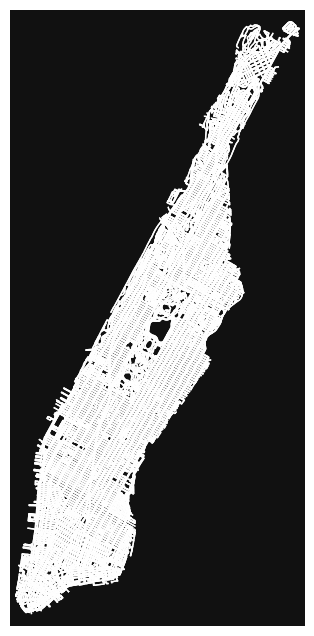

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
#check2
ox.plot_graph(G, node_size=0, edge_color="white")

In [15]:
#check3
import pandas as pd
df = pd.read_csv("edges.csv")
df.head()
df.shape

/var/folders/z8/6ldbxn9140g5h_3x3qprykt40000gn/T/ipykernel_60247/2994216440.py:3: DtypeWarning: Columns (16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("edges.csv")


(120016, 18)

In [17]:
#check4
print("Nodes:", G2.number_of_nodes())
print("Edges:", G2.number_of_edges())

Nodes: 37444
Edges: 120016


# 4. Risk Scoring Engineer

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [3]:
df = pd.read_csv('/Users/mac/Desktop/manhattan_edges_with_counts.csv')  

print(len(df))
print(f"\n shape: {df.shape}")
print(df.head())

120016

 shape: (120016, 13)
   edge_id         u           v      osmid    highway                   name  \
0        0  30807314  2057103273   46613689  bridleway                    NaN   
1        1  30807314  6579409036   46613689  bridleway                    NaN   
2        2  30807314  4303265016  147089927    footway                    NaN   
3        3  30807314  1203806304  147089927    footway                    NaN   
4        4  30978747    42442164  429504381       path  Central Park Driveway   

       length                                           geom_wkt  \
0  159.255042  LINESTRING(-73.9635764 40.7907204,-73.9636016 ...   
1   58.144181  LINESTRING(-73.9635764 40.7907204,-73.9635442 ...   
2   10.509449  LINESTRING(-73.9635764 40.7907204,-73.9635256 ...   
3   17.645411  LINESTRING(-73.9635764 40.7907204,-73.9636781 ...   
4   18.986534  LINESTRING(-73.973425 40.7742666,-73.973649 40...   

   complaint_cnt  arrest_cnt  crash_cnt  cctv_cnt  total_incidents  
0     

In [3]:
print(df.isnull().sum())

edge_id                0
u                      0
v                      0
osmid                  0
highway                0
name               97986
length                 0
geom_wkt               0
complaint_cnt          0
arrest_cnt             0
crash_cnt              0
cctv_cnt               0
total_incidents        0
dtype: int64


In [4]:
#Step 1: Log Transform
df['complaint_log'] = np.log1p(df['complaint_cnt'])
df['arrest_log'] = np.log1p(df['arrest_cnt'])
df['crash_log'] = np.log1p(df['crash_cnt'])
df['cctv_log'] = np.log1p(df['cctv_cnt'])

#Step 2: MinMax
scaler = MinMaxScaler()
df[['complaint_norm', 'arrest_norm', 'crash_norm', 'cctv_norm']] = scaler.fit_transform(
    df[['complaint_log', 'arrest_log', 'crash_log', 'cctv_log']]
)

print(df[['complaint_norm', 'arrest_norm', 'crash_norm', 'cctv_norm']].describe())

       complaint_norm    arrest_norm     crash_norm      cctv_norm
count   120016.000000  120016.000000  120016.000000  120016.000000
mean         0.240036       0.174116       0.274323       0.014410
std          0.202582       0.177101       0.246731       0.072864
min          0.000000       0.000000       0.000000       0.000000
25%          0.000000       0.000000       0.000000       0.000000
50%          0.256961       0.132663       0.246638       0.000000
75%          0.393798       0.300065       0.493276       0.000000
max          1.000000       1.000000       1.000000       1.000000


In [5]:
# Calculate risk scores
# Risk = 0.35×arrests + 0.25×complaints + 0.30×crashes - 0.10×CCTV
df['risk_score'] = (
    0.35 * df['arrest_norm'] +
    0.25 * df['complaint_norm'] +
    0.30 * df['crash_norm'] -
    0.10 * df['cctv_norm']
)

df['risk_score'] = df['risk_score'].clip(0, 1)

print(df['risk_score'].describe())

print(df['risk_score'].mean())
print(df['risk_score'].median())

count    120016.000000
mean          0.201882
std           0.170732
min           0.000000
25%           0.000000
50%           0.205479
75%           0.334931
max           0.827390
Name: risk_score, dtype: float64
0.2018821076850439
0.2054791582689709


In [6]:
#Define the threshold using quantiles
p50 = df['risk_score'].quantile(0.50) 
p75 = df['risk_score'].quantile(0.75)
p90 = df['risk_score'].quantile(0.90)
#classification
df['risk_level'] = pd.cut(
    df['risk_score'],
    bins=[0, p50, p75, p90, df['risk_score'].max() + 0.001],
    labels=['Low', 'Medium', 'High', 'Very High'],
    include_lowest=True
)
#show stat
risk_dist = df['risk_level'].value_counts().sort_index()
for level in ['Low', 'Medium', 'High', 'Very High']:
    count = risk_dist.get(level, 0)
    pct = count / len(df) * 100
    print(f"  {level:12} : {count:6,} edges ({pct:5.1f}%)")

  Low          : 60,008 edges ( 50.0%)
  Medium       : 30,006 edges ( 25.0%)
  High         : 18,000 edges ( 15.0%)
  Very High    : 12,002 edges ( 10.0%)


In [7]:
print(df['risk_score'].describe())

count    120016.000000
mean          0.201882
std           0.170732
min           0.000000
25%           0.000000
50%           0.205479
75%           0.334931
max           0.827390
Name: risk_score, dtype: float64


In [8]:
#Save the final result
output_cols = [
    'edge_id', 'u', 'v', 'length',
    'complaint_cnt', 'arrest_cnt', 'crash_cnt', 'cctv_cnt',
    'complaint_norm', 'arrest_norm', 'crash_norm', 'cctv_norm',
    'risk_score', 'risk_level', 'total_incidents',
    'geom_wkt'
]

output_cols = [col for col in output_cols if col in df.columns]

df_output = df[output_cols].copy()

In [ ]:
from shapely import wkt
import geopandas as gpd
#WKT → geometry
df_output['geometry'] = df_output['geom_wkt'].apply(wkt.loads)
#Convert to a GeoDataFrame (for outputting GeoJSON)
gdf = gpd.GeoDataFrame(df_output, geometry='geometry', crs="EPSG:4326")

In [ ]:
#output CSV and Json
df_output.to_csv("edge_risk_scores_final.csv", index=False)

##api version (edge_id + score + level)
df_api = df[['edge_id', 'risk_score', 'risk_level']].copy()
df_api.to_csv("edge_risk_scores_api.csv", index=False)

##for frontend and flask
gdf[['edge_id', 'risk_score', 'risk_level', 'geometry']].to_file(
    "edges.geojson",
    driver="GeoJSON"
)

# 5.Routing_API

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point


In [2]:
data_complaint = pd.read_csv(
    "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/NYPD_Complaint_Data_Historic_20251029.csv",
    low_memory=False
)


In [3]:
data_arrest = pd.read_csv(
    "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/NYPD_Arrests_Data_(Historic)_20251029.csv",
    low_memory=False
)

In [4]:
data_complaint.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,298687088,11/29/2024,00:01:00,11/29/2024,09:00:00,114.0,12/31/2024,109,GRAND LARCENY,421.0,...,U,NaN,40.759542,-73.937906,"(40.759542, -73.937906)",PATROL BORO QUEENS NORTH,(null),UNKNOWN,UNKNOWN,D
1,298692911,12/31/2024,10:26:00,12/31/2024,10:45:00,32.0,12/31/2024,578,HARRASSMENT 2,638.0,...,M,NaN,40.825363,-73.938070,"(40.825363, -73.93807)",PATROL BORO MAN NORTH,(null),25-44,BLACK HISPANIC,F
2,298703821,12/31/2024,14:30:00,12/31/2024,14:40:00,63.0,12/31/2024,578,HARRASSMENT 2,638.0,...,U,NaN,40.620865,-73.934988,"(40.62086516580702, -73.93498791730437)",PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,F
3,298703791,12/30/2024,23:00:00,12/30/2024,23:15:00,48.0,12/31/2024,341,PETIT LARCENY,352.0,...,(null),NaN,40.845045,-73.880417,"(40.845045, -73.880417)",PATROL BORO BRONX,(null),25-44,UNKNOWN,F
4,298703705,12/31/2024,21:30:00,12/31/2024,21:31:00,14.0,12/31/2024,109,GRAND LARCENY,415.0,...,U,NaN,40.754841,-73.984119,"(40.75484094960602, -73.98411854690194)",PATROL BORO MAN SOUTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F


In [5]:
data_complaint_ytd=pd.read_csv("/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/NYPD_Complaint_Data_Current_(Year_To_Date)_20251029.csv",low_memory=False
)

In [6]:
data_complaint_ytd=data_complaint_ytd[data_complaint.columns]
complaint_df=pd.concat([data_complaint,data_complaint_ytd],ignore_index=True)

In [7]:
complaint_df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,298687088,11/29/2024,00:01:00,11/29/2024,09:00:00,114.0,12/31/2024,109,GRAND LARCENY,421.0,...,U,NaN,40.759542,-73.937906,"(40.759542, -73.937906)",PATROL BORO QUEENS NORTH,(null),UNKNOWN,UNKNOWN,D
1,298692911,12/31/2024,10:26:00,12/31/2024,10:45:00,32.0,12/31/2024,578,HARRASSMENT 2,638.0,...,M,NaN,40.825363,-73.938070,"(40.825363, -73.93807)",PATROL BORO MAN NORTH,(null),25-44,BLACK HISPANIC,F
2,298703821,12/31/2024,14:30:00,12/31/2024,14:40:00,63.0,12/31/2024,578,HARRASSMENT 2,638.0,...,U,NaN,40.620865,-73.934988,"(40.62086516580702, -73.93498791730437)",PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,F
3,298703791,12/30/2024,23:00:00,12/30/2024,23:15:00,48.0,12/31/2024,341,PETIT LARCENY,352.0,...,(null),NaN,40.845045,-73.880417,"(40.845045, -73.880417)",PATROL BORO BRONX,(null),25-44,UNKNOWN,F
4,298703705,12/31/2024,21:30:00,12/31/2024,21:31:00,14.0,12/31/2024,109,GRAND LARCENY,415.0,...,U,NaN,40.754841,-73.984119,"(40.75484094960602, -73.98411854690194)",PATROL BORO MAN SOUTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F


In [8]:
cols=['CMPLNT_NUM', 'RPT_DT','LAW_CAT_CD','Latitude','Longitude']
complaint=complaint_df[cols]

In [9]:
complaint.head()

,CMPLNT_NUM,RPT_DT,LAW_CAT_CD,Latitude,Longitude
0,298687088,12/31/2024,FELONY,40.759542,-73.937906
1,298692911,12/31/2024,VIOLATION,40.825363,-73.938070
2,298703821,12/31/2024,VIOLATION,40.620865,-73.934988
3,298703791,12/31/2024,MISDEMEANOR,40.845045,-73.880417
4,298703705,12/31/2024,FELONY,40.754841,-73.984119


In [10]:
complaint.to_csv( "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/Complaint.csv", index=False)

In [11]:
complaint.isna().mean().sort_values(ascending=False).head(20)

Latitude      0.000048
Longitude     0.000048
CMPLNT_NUM    0.000000
RPT_DT        0.000000
LAW_CAT_CD    0.000000
dtype: float64

In [12]:
complaint[['Latitude','Longitude']].describe()

,Latitude,Longitude
count,9.930023e+06,9.930023e+06
mean,4.072352e+01,-7.390322e+01
std,7.046793e-01,1.272231e+00
min,0.000000e+00,-7.425495e+01
25%,4.067333e+01,-7.397324e+01
50%,4.073307e+01,-7.392689e+01
75%,4.081211e+01,-7.388181e+01
max,4.091296e+01,0.000000e+00


In [13]:
complaint['CMPLNT_NUM'].nunique(), len(complaint) - complaint['CMPLNT_NUM'].nunique()

(9929396, 1106)

In [14]:
complaint= complaint[(complaint['Latitude'] != 0) &
    (complaint['Longitude'] != 0)
]

In [15]:
complaint = complaint.dropna(subset=['Latitude', 'Longitude'])

In [16]:
complaint.isna().mean().sort_values(ascending=False).head(20)

CMPLNT_NUM    0.0
RPT_DT        0.0
LAW_CAT_CD    0.0
Latitude      0.0
Longitude     0.0
dtype: float64

In [17]:
complaint['RPT_DT'] = pd.to_datetime(complaint['RPT_DT'], errors='coerce', format='%m/%d/%Y')

In [18]:
complaint.head()

,CMPLNT_NUM,RPT_DT,LAW_CAT_CD,Latitude,Longitude
0,298687088,2024-12-31,FELONY,40.759542,-73.937906
1,298692911,2024-12-31,VIOLATION,40.825363,-73.938070
2,298703821,2024-12-31,VIOLATION,40.620865,-73.934988
3,298703791,2024-12-31,MISDEMEANOR,40.845045,-73.880417
4,298703705,2024-12-31,FELONY,40.754841,-73.984119


In [19]:
complaint['CMPLNT_NUM'][complaint['CMPLNT_NUM'].duplicated()].unique()

array(['279833457', '24084102', '24084573', ..., '10008294', '9932582',
       '298859540'], shape=(1105,), dtype=object)

In [20]:
complaint = complaint.drop_duplicates(subset='CMPLNT_NUM', keep='first')

In [21]:
complaint['CMPLNT_NUM'].is_unique

True

In [22]:
complaint.describe()

,RPT_DT,Latitude,Longitude
count,9925987,9.925987e+06,9.925987e+06
mean,2015-11-16 22:04:50.698026240,4.073554e+01,-7.392504e+01
min,2006-01-01 00:00:00,4.049804e+01,-7.425495e+01
25%,2010-09-22 00:00:00,4.067339e+01,-7.397324e+01
50%,2015-09-26 00:00:00,4.073314e+01,-7.392694e+01
75%,2021-03-06 00:00:00,4.081213e+01,-7.388184e+01
max,2025-09-30 00:00:00,4.091296e+01,-7.370029e+01
std,NaN,8.322546e-02,7.744213e-02


In [23]:
import psycopg2
import pandas as pd
from io import StringIO

In [24]:
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="postgres",      
    user="postgres",
    password="123"   
)
conn.autocommit = True      
cur = conn.cursor()


In [25]:
cur.execute("""
DO $$
BEGIN
    IF NOT EXISTS (SELECT FROM pg_database WHERE datname = 'project') THEN
        CREATE DATABASE project;
    END IF;
END $$;
""")
print("✅ Database project already exists or has been successfully created")


✅ Database project already exists or has been successfully created


In [26]:
conn = psycopg2.connect(
    host="localhost",
    port="5432",
    dbname="project",           
    user="postgres",
    password="123"
)
cur = conn.cursor()

print("✅ Connected to the project database!")

✅ Connected to the project database!


In [27]:
conn.rollback()
cur.execute("CREATE EXTENSION IF NOT EXISTS postgis;")
conn.commit()
print("✅The PostGIS extension has been enabled (or already exists)！")

✅The PostGIS extension has been enabled (or already exists)！


In [28]:
conn.rollback()
cur.execute("""
CREATE TABLE IF NOT EXISTS complaint (
    id SERIAL PRIMARY KEY,
    cmplnt_num VARCHAR(20),
    cmplnt_fr_dt DATE,
    ofns_desc VARCHAR(255),
    law_cat_cd VARCHAR(20),
    latitude DOUBLE PRECISION,
    longitude DOUBLE PRECISION,
    geom GEOMETRY(Point, 4326)
);
""")
conn.commit()
print("✅ The complaint table already exists or has been successfully created！")


✅ The complaint table already exists or has been successfully created！


In [29]:
cur.execute("ALTER TABLE complaint ALTER COLUMN law_cat_cd TYPE VARCHAR(20);")
conn.commit()

In [30]:
buffer = StringIO()
complaint.to_csv(buffer, index=False, header=False)
buffer.seek(0)

0

In [31]:
print(buffer.getvalue()[:500])


298687088,2024-12-31,FELONY,40.759542,-73.937906
298692911,2024-12-31,VIOLATION,40.825363,-73.93807
298703821,2024-12-31,VIOLATION,40.62086516581,-73.9349879173
298703791,2024-12-31,MISDEMEANOR,40.845045,-73.880417
298703705,2024-12-31,FELONY,40.75484094961,-73.9841185469
298697850,2024-12-31,MISDEMEANOR,40.79156983326,-73.94467676957
298697918,2024-12-31,MISDEMEANOR,40.642883,-73.984323
298702353,2024-12-31,MISDEMEANOR,40.815065,-73.935947
298807754,2024-12-31,MISDEMEANOR,40.567366,-74.112885
2


In [33]:
try:
    conn.rollback()  # Clear out any possible erroneous transactions first
    buffer.seek(0)
    cur.copy_expert("""
    COPY complaint (cmplnt_num, cmplnt_fr_dt, law_cat_cd, latitude, longitude)
    FROM STDIN WITH (FORMAT CSV);
""", buffer)


    conn.commit()
    print("✅ The data has been successfully imported into the complaint table！")

except Exception as e:
    conn.rollback()
    print("❌ Error：", e)


✅ The data has been successfully imported into the complaint table！


In [34]:
conn.commit()
cur.execute("SELECT COUNT(*) FROM complaint;")
print("✅ The current number of rows in the complaint table：", cur.fetchone()[0])

✅ The current number of rows in the complaint table： 39703948


In [35]:
conn.commit()
print(f"✅ Successfully imported {len(complaint)} rows into complaint table!")

✅ Successfully imported 9925987 rows into complaint table!


In [1]:
import pandas as pd

edges_path = "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/edge_risk_scores_final.csv" 
df_full = pd.read_csv(edges_path)

df_full.head()


,edge_id,u,v,length,complaint_cnt,arrest_cnt,crash_cnt,cctv_cnt,complaint_norm,arrest_norm,crash_norm,cctv_norm,risk_score,risk_level,total_incidents,geom_wkt,geometry
0,0,30807314,2057103273,159.255042,0,0,0,0,0.0,0.0,0.0,0.0,0.0,Low,0,"LINESTRING(-73.9635764 40.7907204,-73.9636016 ...","LINESTRING (-73.9635764 40.7907204, -73.963601..."
1,1,30807314,6579409036,58.144181,0,0,0,0,0.0,0.0,0.0,0.0,0.0,Low,0,"LINESTRING(-73.9635764 40.7907204,-73.9635442 ...","LINESTRING (-73.9635764 40.7907204, -73.963544..."
2,2,30807314,4303265016,10.509449,0,0,0,0,0.0,0.0,0.0,0.0,0.0,Low,0,"LINESTRING(-73.9635764 40.7907204,-73.9635256 ...","LINESTRING (-73.9635764 40.7907204, -73.963525..."
3,3,30807314,1203806304,17.645411,0,0,0,0,0.0,0.0,0.0,0.0,0.0,Low,0,"LINESTRING(-73.9635764 40.7907204,-73.9636781 ...","LINESTRING (-73.9635764 40.7907204, -73.963678..."
4,4,30978747,42442164,18.986534,0,0,0,0,0.0,0.0,0.0,0.0,0.0,Low,0,"LINESTRING(-73.973425 40.7742666,-73.973649 40...","LINESTRING (-73.973425 40.7742666, -73.973649 ..."


In [2]:
df_edges = df_full[["edge_id", "u", "v", "risk_score"]].copy()
df_edges.head()

,edge_id,u,v,risk_score
0,0,30807314,2057103273,0.0
1,1,30807314,6579409036,0.0
2,2,30807314,4303265016,0.0
3,3,30807314,1203806304,0.0
4,4,30978747,42442164,0.0


In [3]:
import networkx as nx

G = nx.Graph()

for _, row in df_edges.iterrows():
    u = row["u"]
    v = row["v"]
    risk = row["risk_score"]
    eid = row["edge_id"]

    G.add_edge(u, v, risk=risk, edge_id=eid)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 37444
Number of edges: 59613


In [4]:
nodes = list(G.nodes())
len(nodes), nodes[:10]   # Take a look at what the first 10 nodes look like

(37444,
 [np.float64(30807314.0),
  np.float64(2057103273.0),
  np.float64(6579409036.0),
  np.float64(4303265016.0),
  np.float64(1203806304.0),
  np.float64(30978747.0),
  np.float64(42442164.0),
  np.float64(4257949439.0),
  np.float64(4256322265.0),
  np.float64(4286592925.0)])

In [5]:
start_node = nodes[0]
end_node = nodes[10] 

print("start:", start_node, "end:", end_node)

# Run Dijkstra with risk_score as the weight
path_nodes = nx.shortest_path(G, source=start_node, target=end_node, weight="risk")
path_nodes

start: 30807314.0 end: 30978752.0


[np.float64(30807314.0),
 np.float64(2057103273.0),
 np.float64(3248816542.0),
 np.float64(3248816541.0),
 np.float64(1901016279.0),
 np.float64(1901016275.0),
 np.float64(1901016230.0),
 np.float64(1901016210.0),
 np.float64(1901016203.0),
 np.float64(6579395863.0),
 np.float64(6579395861.0),
 np.float64(3248816540.0),
 np.float64(2059304004.0),
 np.float64(1209744536.0),
 np.float64(2059303953.0),
 np.float64(1203887491.0),
 np.float64(3248816636.0),
 np.float64(1782787521.0),
 np.float64(3248816356.0),
 np.float64(3248816676.0),
 np.float64(248709587.0),
 np.float64(3248816675.0),
 np.float64(2291198318.0),
 np.float64(3248816681.0),
 np.float64(2291198290.0),
 np.float64(2059303879.0),
 np.float64(30978752.0)]

In [6]:
path_edge_ids = []

for u, v in zip(path_nodes[:-1], path_nodes[1:]):
    edge_data = G[u][v]          # The attribute dictionary on this side
    path_edge_ids.append(edge_data["edge_id"])

path_edge_ids


[np.float64(8834.0),
 np.float64(11556.0),
 np.float64(11555.0),
 np.float64(11553.0),
 np.float64(8719.0),
 np.float64(8717.0),
 np.float64(8711.0),
 np.float64(8697.0),
 np.float64(31090.0),
 np.float64(31092.0),
 np.float64(31088.0),
 np.float64(11551.0),
 np.float64(8983.0),
 np.float64(8974.0),
 np.float64(8975.0),
 np.float64(11601.0),
 np.float64(11600.0),
 np.float64(11503.0),
 np.float64(11636.0),
 np.float64(11635.0),
 np.float64(11632.0),
 np.float64(11634.0),
 np.float64(11646.0),
 np.float64(11645.0),
 np.float64(9309.0),
 np.float64(8963.0)]

In [7]:
class RouteEngine:
    def __init__(self, df_edges):
        """
        df_edges: It must at least include ['edge_id', 'u', 'v', 'risk_score']
        """
        self.df_edges = df_edges
        self.graph = self._build_graph()

    def _build_graph(self):
        G = nx.Graph()
        for _, row in self.df_edges.iterrows():
            u = row["u"]
            v = row["v"]
            risk = row["risk_score"]
            eid = row["edge_id"]
            G.add_edge(u, v, risk=risk, edge_id=eid)
        return G

    def safest_path(self, source, target):
        """
        Return (node path, edge id list)
        """
        path_nodes = nx.shortest_path(
            self.graph,
            source=source,
            target=target,
            weight="risk"
        )

        path_edge_ids = []
        for u, v in zip(path_nodes[:-1], path_nodes[1:]):
            edge_data = self.graph[u][v]
            path_edge_ids.append(edge_data["edge_id"])

        return path_nodes, path_edge_ids


In [8]:
engine = RouteEngine(df_edges)

nodes = list(engine.graph.nodes())
start_node = nodes[0]
end_node   = nodes[10]

nodes_path, edges_path = engine.safest_path(start_node, end_node)

print("Node path：", nodes_path[:10], " ...")
print("Edge ID path：", edges_path[:10], " ...")


Node path： [np.float64(30807314.0), np.float64(2057103273.0), np.float64(3248816542.0), np.float64(3248816541.0), np.float64(1901016279.0), np.float64(1901016275.0), np.float64(1901016230.0), np.float64(1901016210.0), np.float64(1901016203.0), np.float64(6579395863.0)]  ...
Edge ID path： [np.float64(8834.0), np.float64(11556.0), np.float64(11555.0), np.float64(11553.0), np.float64(8719.0), np.float64(8717.0), np.float64(8711.0), np.float64(8697.0), np.float64(31090.0), np.float64(31092.0)]  ...


In [9]:
%%writefile route_engine.py
import pandas as pd
import networkx as nx


class RouteEngine:
    """
    Build the road network from the CSV with edge_id, u, v, risk_score
    And provide the safest_path method to calculate the safest path based on risk weights.
    """

    def __init__(self, edges_csv_path: str):
        self.edges_csv_path = edges_csv_path
        self.graph = nx.Graph()
        self._build_graph()

    def _build_graph(self):
        df = pd.read_csv(self.edges_csv_path)

        # Only retain the necessary columns to prevent the influence of redundant columns
        df_edges = df[["edge_id", "u", "v", "risk_score"]].copy()

        # Optional: Convert the node and edge_id to int to avoid float64 having decimal points
        df_edges["u"] = df_edges["u"].astype(int)
        df_edges["v"] = df_edges["v"].astype(int)
        df_edges["edge_id"] = df_edges["edge_id"].astype(int)

        for _, row in df_edges.iterrows():
            u = row["u"]
            v = row["v"]
            risk = row["risk_score"]
            eid = row["edge_id"]

            self.graph.add_edge(u, v, risk=risk, edge_id=eid)

    def safest_path(self, source, target):
        """
        Return (node path, edge ID path) based on the risk weight
        source, target: Node id (consistent with u/v in CSV)
        """
        path_nodes = nx.shortest_path(
            self.graph,
            source=source,
            target=target,
            weight="risk"
        )

        path_edge_ids = []
        for u, v in zip(path_nodes[:-1], path_nodes[1:]):
            edge_data = self.graph[u][v]
            path_edge_ids.append(edge_data["edge_id"])

        return path_nodes, path_edge_ids


Overwriting route_engine.py


In [10]:
from route_engine import RouteEngine

# Build the road network with the full version of CSV
engine = RouteEngine("/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/edge_risk_scores_final.csv") 

print("Number of nodes：", engine.graph.number_of_nodes())
print("Edge count：", engine.graph.number_of_edges())

nodes = list(engine.graph.nodes())
start_node = nodes[0]
end_node   = nodes[10]

nodes_path, edges_path = engine.safest_path(start_node, end_node)

print("The top 10 node paths：", nodes_path[:10])
print("The first 10 edge ID paths：", edges_path[:10])

Number of nodes： 37444
Edge count： 59613
The top 10 node paths： [np.float64(30807314.0), np.float64(2057103273.0), np.float64(3248816542.0), np.float64(3248816541.0), np.float64(1901016279.0), np.float64(1901016275.0), np.float64(1901016230.0), np.float64(1901016210.0), np.float64(1901016203.0), np.float64(6579395863.0)]
The first 10 edge ID paths： [np.float64(8834.0), np.float64(11556.0), np.float64(11555.0), np.float64(11553.0), np.float64(8719.0), np.float64(8717.0), np.float64(8711.0), np.float64(8697.0), np.float64(31090.0), np.float64(31092.0)]


In [11]:
%%writefile app.py
import os
import json
from flask import Flask, request, jsonify

from route_engine import RouteEngine


#Path Settings (Adjust according to your own directory)
BASE_DIR = os.path.dirname(os.path.abspath(__file__))

# Use the full version of CSV for routing
CSV_PATH = os.path.join(
    BASE_DIR,
    "data",
    "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/edge_risk_scores_final.csv" 
)

# Render the route using geojson
GEOJSON_PATH = os.path.join(
    BASE_DIR,
    "data",
    "/Users/jindian/Desktop/5400Fundamentals of Data Engineering/project/edges.geojson"  
)


#Initialize RouteEngine (load CSV + Build the map)
route_engine = RouteEngine(CSV_PATH)


#Load GeoJSON and create the index of edge_id -> feature
with open(GEOJSON_PATH, "r", encoding="utf-8") as f:
    edges_geojson = json.load(f)

edge_index = {}
for feat in edges_geojson["features"]:
    props = feat.get("properties", {})
    eid = props.get("edge_id")
    if eid is None:
        continue
    try:
        eid_int = int(float(eid))  
        edge_index[eid_int] = feat
    except (ValueError, TypeError):
        continue


#Create a Flask app
app = Flask(__name__)


@app.route("/route", methods=["GET"])
def get_route():
    """
    Calling method:
    /route?start=<node_id>&end=<node_id>

    start/end is the node id in the road network (the same as u/v in CSV)
    Return: The GeoJSON FeatureCollection corresponding to a secure path
    """
    start = request.args.get("start")
    end = request.args.get("end")

    if start is None or end is None:
        return jsonify({"error": "The start and end parameters need to be provided"}), 400

    # Convert a string to a number (either int or float is acceptable)
    try:
        start_node = int(float(start))
        end_node = int(float(end))
    except ValueError:
        return jsonify({"error": "start/end must be the node id"}), 400

    # Use your RouteEngine to find the safest path
    try:
        node_path, edge_ids = route_engine.safest_path(start_node, end_node)
    except Exception as e:
        return jsonify({"error": f"routing fail: {str(e)}"}), 500

    # Find the corresponding feature in geojson based on edge_id
    features = []
    for eid in edge_ids:
        # Some edges may not exist in geojson, so skip them
        feat = edge_index.get(int(eid))  
        if feat:
            features.append(feat)

    route_geojson = {
        "type": "FeatureCollection",
        "features": features,
        "properties": {
            "start": start_node,
            "end": end_node,
            "node_count": len(node_path),
            "edge_count": len(features)
        }
    }

    return jsonify(route_geojson)


if __name__ == "__main__":
    # debug=True makes it convenient to view errors during development. The default port=5000 is fine
    app.run(host="0.0.0.0", port=5001, debug=True)


Overwriting app.py


In [13]:
import requests
import json

BASE_URL = "http://127.0.0.1:5001"   

# Use the pair of nodes just tested (pick any two from RouteEngine)
start_node = nodes[0]    
end_node   = nodes[10]    

params = {
    "start": int(start_node),
    "end": int(end_node)
}

r = requests.get(f"{BASE_URL}/route", params=params)
print("Status code:", r.status_code)

data = r.json()
print("keys:", data.keys())
print("feature number:", len(data.get("features", [])))
print(json.dumps(data, indent=2)[:1000])  


Status code: 200
keys: dict_keys(['features', 'properties', 'type'])
feature number: 26
{
  "features": [
    {
      "geometry": {
        "coordinates": [
          [
            -73.963831,
            40.7893886
          ],
          [
            -73.9638275,
            40.7894656
          ],
          [
            -73.9638314,
            40.7895377
          ],
          [
            -73.9638403,
            40.7896212
          ],
          [
            -73.9638512,
            40.7897077
          ],
          [
            -73.9638627,
            40.7897795
          ],
          [
            -73.9638862,
            40.7898967
          ],
          [
            -73.9639022,
            40.7899938
          ],
          [
            -73.9639183,
            40.7901293
          ],
          [
            -73.9639289,
            40.7902202
          ],
          [
            -73.9639385,
            40.7903173
          ],
          [
            -73.9639266,
    

In [1]:
import requests
import json

BASE_URL = "http://127.0.0.1:5001"


In [3]:
params = {"start": 30807314, "end": 30978752}  # Replace it with the node that has a way
r = requests.get(f"{BASE_URL}/route", params=params)
print("Status:", r.status_code)
route_geojson = r.json()
print(json.dumps(route_geojson, indent=2)[:1000])  


Status: 200
{
  "features": [
    {
      "geometry": {
        "coordinates": [
          [
            -73.963831,
            40.7893886
          ],
          [
            -73.9638275,
            40.7894656
          ],
          [
            -73.9638314,
            40.7895377
          ],
          [
            -73.9638403,
            40.7896212
          ],
          [
            -73.9638512,
            40.7897077
          ],
          [
            -73.9638627,
            40.7897795
          ],
          [
            -73.9638862,
            40.7898967
          ],
          [
            -73.9639022,
            40.7899938
          ],
          [
            -73.9639183,
            40.7901293
          ],
          [
            -73.9639289,
            40.7902202
          ],
          [
            -73.9639385,
            40.7903173
          ],
          [
            -73.9639266,
            40.7903797
          ],
          [
            -73.9639098,
       

In [3]:
payload = {
    "location": {"lat": 40.7128, "lon": -74.0060},
    "type": "unsafe_area",
    "timestamp": "2025-11-29T16:10:00"
}
r = requests.post(f"{BASE_URL}/reports/new", json=payload)
print("Status:", r.status_code)
print(r.json())


Status: 200
{'status': 'ok'}


In [4]:
params = {"lat": 40.7128, "lon": -74.0060}
r = requests.get(f"{BASE_URL}/reports/nearby", params=params)
print("Status:", r.status_code)
print(json.dumps(r.json(), indent=2))

Status: 200
[
  {
    "_id": "692b6bdf2ceb168032a573cd",
    "location": {
      "lat": 40.7128,
      "lon": -74.006
    },
    "timestamp": "2025-11-29T16:10:00",
    "type": "unsafe_area"
  },
  {
    "_id": "692b6eb22ceb168032a573ce",
    "location": {
      "lat": 40.7128,
      "lon": -74.006
    },
    "timestamp": "2025-11-29T16:10:00",
    "type": "unsafe_area"
  }
]


# 6. MongoDB Report

In [1]:
# 1. install (run once in terminal / Jupyter)
# !pip install pymongo

from pymongo import MongoClient
from datetime import datetime
import pprint

# ---- connection settings ----
MONGO_URI = "mongodb://localhost:27017"  # local MongoDB
DB_NAME   = "safe_route"
COLL_NAME = "reports"

# ---- connect ----
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
coll = db[COLL_NAME]

print("Connected to:", db, "collection:", coll)

Connected to: Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'safe_route') collection: Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'safe_route'), 'reports')


In [15]:
from pymongo import GEOSPHERE

In [16]:
indexes = coll.index_information()
if "location_2dsphere" not in indexes:
    coll.create_index([("location", GEOSPHERE)], name="location_2dsphere")
    print("✅ Created 2dsphere index on 'location'")
else:
    print("ℹ️ 2dsphere index already exists")

print("Index info:")
pprint.pp(coll.index_information())

✅ Created 2dsphere index on 'location'
Index info:
{'_id_': {'v': 2, 'key': [('_id', 1)]},
 'geo_2dsphere': {'v': 2,
                  'key': [('geo', '2dsphere')],
                  '2dsphereIndexVersion': 3},
 'location_2dsphere': {'v': 2,
                       'key': [('location', '2dsphere')],
                       '2dsphereIndexVersion': 3}}


In [17]:
def make_user_incident(lon, lat, category, severity, description,
                       user_id="demo_user", source="demo", status="open", edge_id=None):
    """
    Build one incident document in the standard format.
    lon, lat: floats (WGS84)
    """
    return {
        "user_id": user_id,          
        "source": source,            
        "category": category,        
        "severity": int(severity),  
        "description": description or "",
        "location": {
            "type": "Point",
            "coordinates": [float(lon), float(lat)]   
        },
        "created_at": datetime.utcnow(),
        "status": status,            
        "edge_id": edge_id           
    }

# Show the structure for documentation
pprint.pp(
    make_user_incident(
        lon=-73.9855,
        lat=40.7580,
        category="unsafe_traffic",
        severity=4,
        description="TEST example – cars turning fast near crossing."
    )
)

{'user_id': 'demo_user',
 'source': 'demo',
 'category': 'unsafe_traffic',
 'severity': 4,
 'description': 'TEST example – cars turning fast near crossing.',
 'location': {'type': 'Point', 'coordinates': [-73.9855, 40.758]},
 'created_at': datetime.datetime(2025, 12, 5, 19, 43, 30, 982861),
 'status': 'open',
 'edge_id': None}


/var/folders/bc/h06b0m716bncjbrwxqm9j4n40000gn/T/ipykernel_71168/1803022171.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow(),


In [18]:
# Rough Manhattan coordinates (lon, lat)
TIMES_SQ      = (-73.9855, 40.7580)
CENTRAL_PARK  = (-73.9742, 40.7690)
UNION_SQ      = (-73.9903, 40.7359)
COLUMBIA      = (-73.9626, 40.8075)
CHINATOWN     = (-73.9973, 40.7158)

demo_docs = [
    make_user_incident(*TIMES_SQ, category="unsafe_traffic", severity=4,
                       description="TEST – cars turning fast, hard to cross."),
    make_user_incident(*TIMES_SQ, category="harassment", severity=3,
                       description="TEST – aggressive shouting late at night."),
    make_user_incident(*CENTRAL_PARK, category="dark_area", severity=2,
                       description="TEST – very dim lighting near park entrance."),
    make_user_incident(*UNION_SQ, category="robbery", severity=5,
                       description="TEST – phone snatch near subway stairs."),
    make_user_incident(*COLUMBIA, category="harassment", severity=3,
                       description="TEST – group blocking sidewalk."),
    make_user_incident(*CHINATOWN, category="unsafe_traffic", severity=4,
                       description="TEST – scooters ignoring red lights.")
]

# Optional: clear previous demo data so you don't duplicate
delete_result = coll.delete_many({"source": "demo"})
print(f"Deleted {delete_result.deleted_count} old demo docs.")

insert_result = coll.insert_many(demo_docs)
print(f"Inserted {len(insert_result.inserted_ids)} demo incidents.")

Deleted 0 old demo docs.
Inserted 6 demo incidents.


/var/folders/bc/h06b0m716bncjbrwxqm9j4n40000gn/T/ipykernel_71168/1803022171.py:17: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "created_at": datetime.utcnow(),


In [19]:
# Example: user standing near Times Square
user_lon, user_lat = TIMES_SQ
radius_m = 500  # search within 500 meters

nearby = list(
    coll.find({
        "location": {
            "$near": {
                "$geometry": {
                    "type": "Point",
                    "coordinates": [user_lon, user_lat]
                },
                "$maxDistance": radius_m
            }
        }
    }).limit(20)
)

print(f"Found {len(nearby)} incidents within {radius_m}m of Times Square:\n")
for d in nearby:
    print(
        "-", d["category"],
        "| severity:", d["severity"],
        "| coords:", d["location"]["coordinates"],
        "| desc:", d["description"]
    )

Found 2 incidents within 500m of Times Square:

- unsafe_traffic | severity: 4 | coords: [-73.9855, 40.758] | desc: TEST – cars turning fast, hard to cross.
- harassment | severity: 3 | coords: [-73.9855, 40.758] | desc: TEST – aggressive shouting late at night.
